# XPCS Pipeline for GiSAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [3]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis)

from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                     get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             init_compress_eigerdata,
                                             Multifile,get_t_iqc,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)
from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)

%matplotlib notebook

In [4]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
#%reset

In [6]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /XPCS_GiSAXS_Multi_Run_Sep.ipynb


## Make a directory for saving results

In [8]:
CYCLE = '2016_2'

username = getpass.getuser()
date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [9]:
start_time, stop_time = '2016-08-02  15:51:55', '2016-08-02  15:55:50'  

hdrs = db(start_time= start_time, stop_time = stop_time)

print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 20 uids are found
(5480, '97ce2ec2-c3bb-47e7-abe9-ede08c01183c', ['/XF11ID/data/2016/08/02/b11421b7-fc57-46ce-8cab_3483'])
(5479, '2c0a9932-d147-41f7-9c8b-84dc8afe46ce', ['/XF11ID/data/2016/08/02/a17323ef-4ebd-481c-9d4b_3482'])
(5478, '14aa5cdf-8d24-434f-adf5-8bfc03040e14', ['/XF11ID/data/2016/08/02/071702c1-b08c-499d-84a0_3481'])
(5477, 'c744b447-f356-45ed-b4fc-88363e7ab13a', ['/XF11ID/data/2016/08/02/d4d13048-e1ff-4a06-a346_3480'])
(5476, '2d7580df-893b-4998-8222-c31d4ab8b01d', ['/XF11ID/data/2016/08/02/3b75a7f9-4b45-433a-96a2_3479'])
(5475, '841c0614-0e59-41db-b1e7-fbb66eae2dcd', ['/XF11ID/data/2016/08/02/82735694-280b-4481-8047_3478'])
(5474, '0c56f77b-59c9-40f2-9516-47c9aa657c5d', ['/XF11ID/data/2016/08/02/0177c34b-ddf1-4bcd-a458_3477'])
(5473, '446bbdd6-617c-4fc4-9cab-3abdf233e195', ['/XF11ID/data/2016/08/02/d9d6b4a1-c4ed-46f5-a8a6_3476'])
(5472, 'eda11800-5b00-4539-8be8-4237a4fdfbff', ['/XF11ID/data/2016/08/02/ec779bc2-e200-4071-baac_3475'])
(5471, '86c43343-9856-4c06-80

In [53]:
uid_=  'PEO39k_Aug02'  #give a meaningful folder name
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/


In [54]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print( data_dir_)

/XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/Average/


# Don't Change these lines below here

In [12]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  5461--ac6a0483-dea7-48c4-b8dd-7c5bff73d675--/XF11ID/data/2016/08/02/3789b921-7e33-484e-aa15_3464


In [13]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/08/02/3789b921-7e33-484e-aa15_3464_master.h5


In [14]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    #md['sample']= 'PS205000-PMMA-207000-SMMA3'
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'
print( md['sample'])    

PEO39k 1krpm Nanograting C2 Line Orthogonal


In [15]:
imgs

<Frames>
Length: 100 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [16]:
md

{'Measurement': 'XPCS: PEO 39k grating C2 T=116.2C att=0.1016 acquire[ 2 ms X 100 fr = 0.2000 s ] series_1_1',
 'beam_center_x': 1331.0,
 'beam_center_y': 807.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'incident_wavelength': 1.2853431,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'PEO39k 1krpm Nanograting C2 Line Orthogonal',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [17]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.84     # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....



The sample is PEO39k 1krpm Nanograting C2 Line Orthogonal
Exposuretime=0.00199 sec, Acquisition_period=0.002 sec


In [18]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe,  path= data_dir_, md=md)

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [19]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'July30_mask.npy' #>= 160 C use this one



<IPython.core.display.Javascript object>


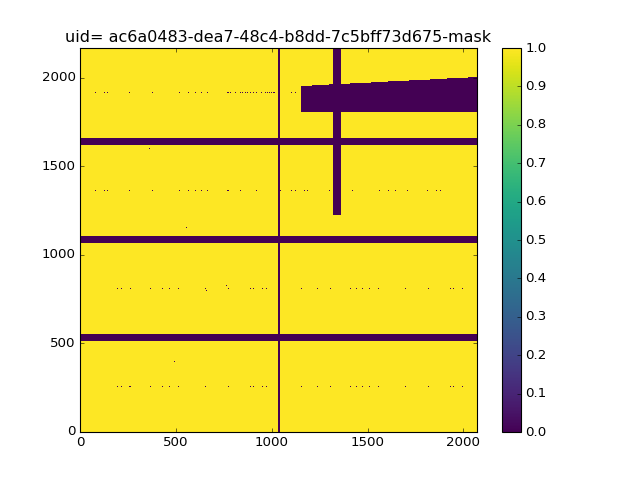

In [20]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [21]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH

In [22]:
maskr = mask[::-1,:]
imgsr = reverse_updown( imgs )
imgsra = apply_mask( imgsr, maskr )

<IPython.core.display.Javascript object>


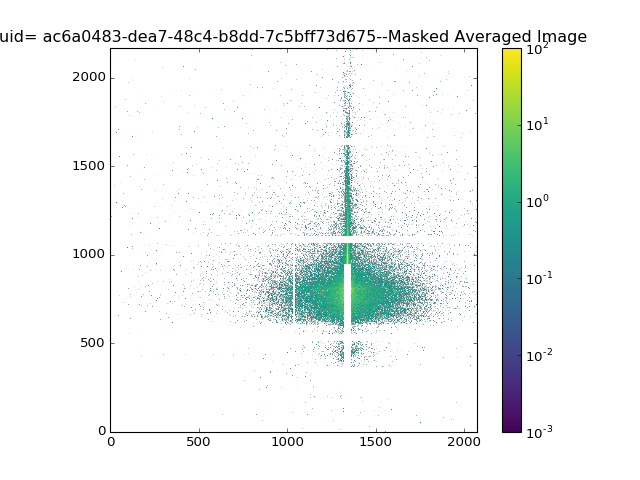

In [23]:
avg_imgr =  get_avg_img( imgsra, sampling = int(Nimg/3), plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


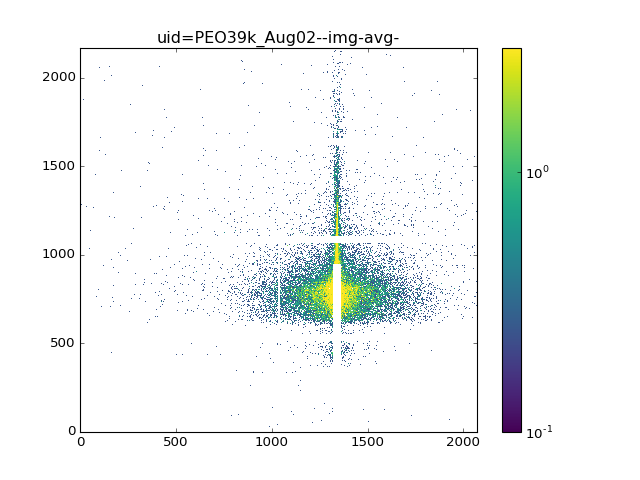

In [24]:
show_img( avg_imgr,  vmin=.1, vmax=3.0, logs=True, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_imgr

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

In [25]:
inc_x0 = 1334
inc_y0 = 424

refl_x0 = 1334
refl_y0 = 760

In [26]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )

The incident_angle (alphai) is: 0.149157086456
The incident_angle (alphai) is: 0.149157086456


<IPython.core.display.Javascript object>


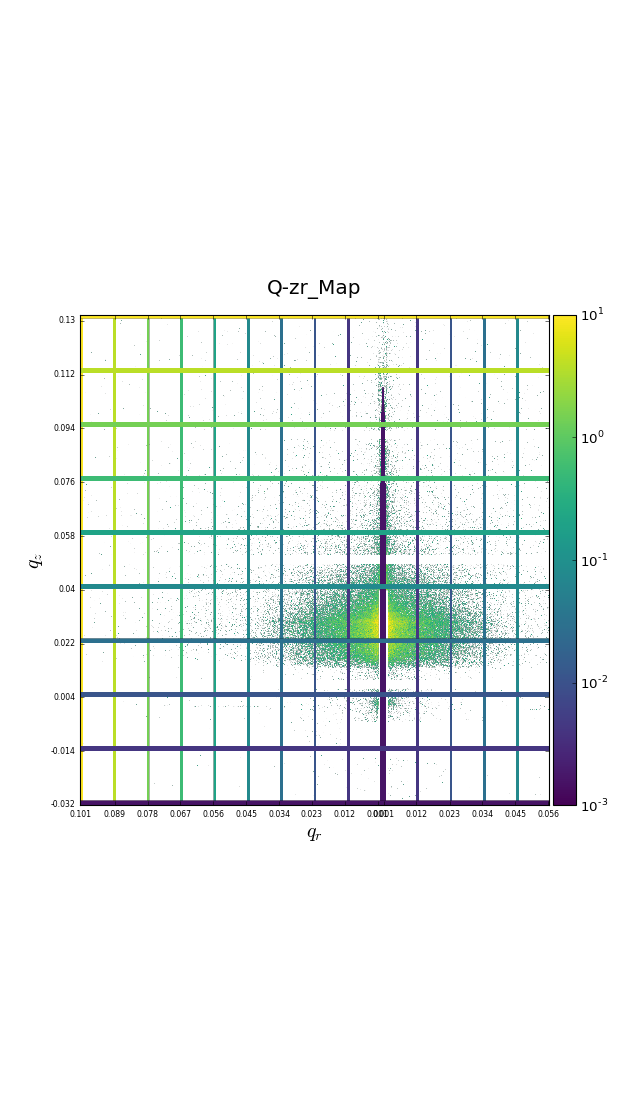

In [27]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

In [28]:
qz_start = 0.02
qz_end = 0.04
qz_num= 3
qz_width = (qz_end - qz_start)/(qz_num +1)


qr_start =  0.005
qr_end = 0.08
qr_num = 10
qr_width = ( qr_end- qr_start)/(qr_num+1)


Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

In [29]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)
labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

<IPython.core.display.Javascript object>


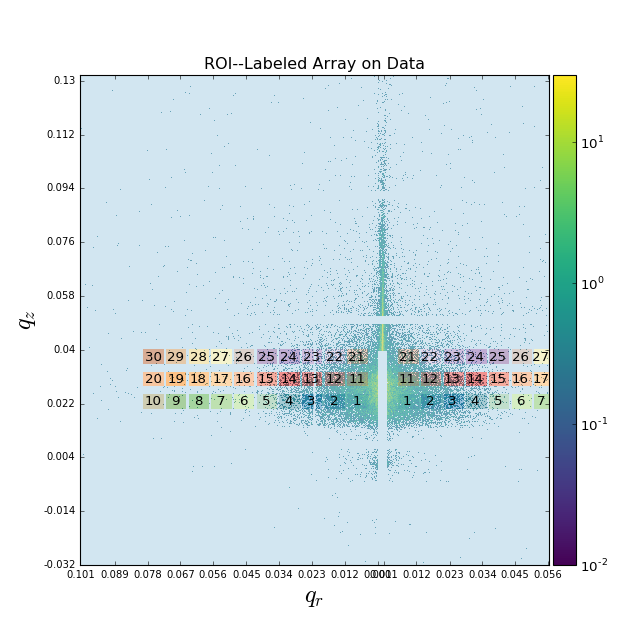

In [30]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks, alpha=0.5, save=True, path=data_dir_, uid=uid_   )

The qr_edge is:  [ 0.005       0.01181818  0.01257576  0.01939394  0.02015152  0.0269697
  0.02772727  0.03454545  0.03530303  0.04212121  0.04287879  0.04969697
  0.05045455  0.05727273  0.0580303   0.06484848  0.06560606  0.07242424
  0.07318182  0.08      ]
The qr_center is:  [ 0.00840909  0.01598485  0.02356061  0.03113636  0.03871212  0.04628788
  0.05386364  0.06143939  0.06901515  0.07659091]
The qz_edge is:  [ 0.02    0.025   0.0275  0.0325  0.035   0.04  ]
The qz_center is:  [ 0.0225  0.03    0.0375]


<IPython.core.display.Javascript object>


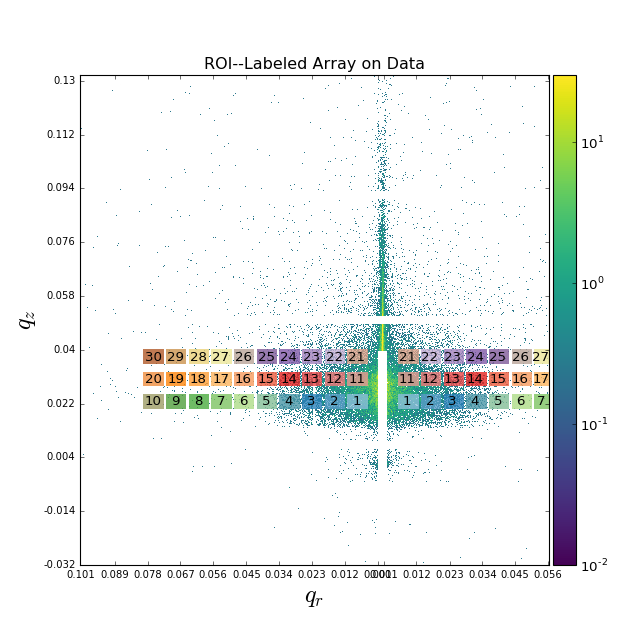

<IPython.core.display.Javascript object>


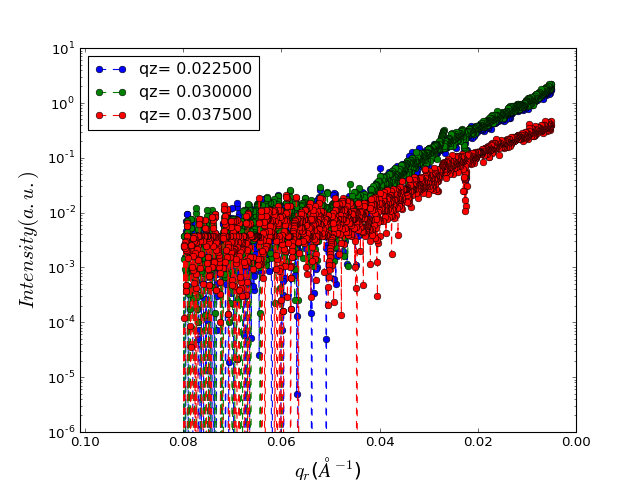

The qr_1d is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/Average/ with filename as uid=PEO39k_Aug02--qr_1d.csv


In [31]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  None,  True, ticks, .8,
                  save= True, setup_pargs=setup_pargs )

<IPython.core.display.Javascript object>


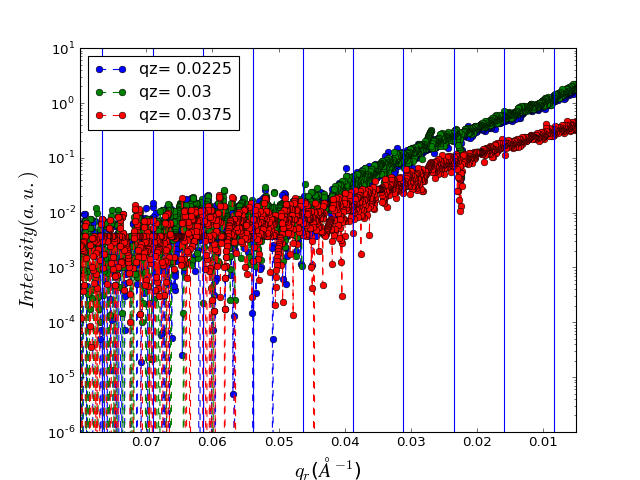

In [32]:
plot_qr_1d_with_ROI( qr_1d, qr_center, loglog=False, save=True, setup_pargs=setup_pargs )

In [33]:
md['ring_mask'] = box_maskr
md['qr_center']= qr_center
md['qr_edge'] = qr_edge
md['qz_center']= qz_center
md['qz_edge'] = qz_edge
md['beam_center_x'] = inc_x0
md['beam_center_y']=  inc_y0
md['refl_center_x'] = refl_x0
md['refl_center_y']=  refl_y0
md['incident angle'] = alphai*180/np.pi
md['data_dir'] = data_dir
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [34]:
print (len( np.where(avg_imgr)[0] ) / ( imgsra[0].size))
compress =  len( np.where(avg_imgr)[0] ) / ( imgsra[0].size) < .1  #if the photon ocupation < 0.1, do compress

print (compress)

0.06264989332744796
True


# Do loop here

In [35]:
run_num =1
sub_num = 20

Averaging images:  23%|██▎       | 23/100 [00:00<00:00, 227.80it/s]

The 0--th uid to be analyzed is : ac6a0483-dea7-48c4-b8dd-7c5bff73d675
hdf5 path = /XF11ID/data/2016/08/02/3789b921-7e33-484e-aa15_3464_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_ac6a0483-dea7-48c4-b8dd-7c5bff73d675.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 924.23it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 24.34it/s]

G2 calculation DONE!
The correlation function of uid= ac6a0483-dea7-48c4-b8dd-7c5bff73d675 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/ac6a0483-dea7-48c4-b8dd-7c5bff73d675/g2-ac6a0483-dea7-48c4-b8dd-7c5bff73d675-20160916-1627-.csv


<IPython.core.display.Javascript object>


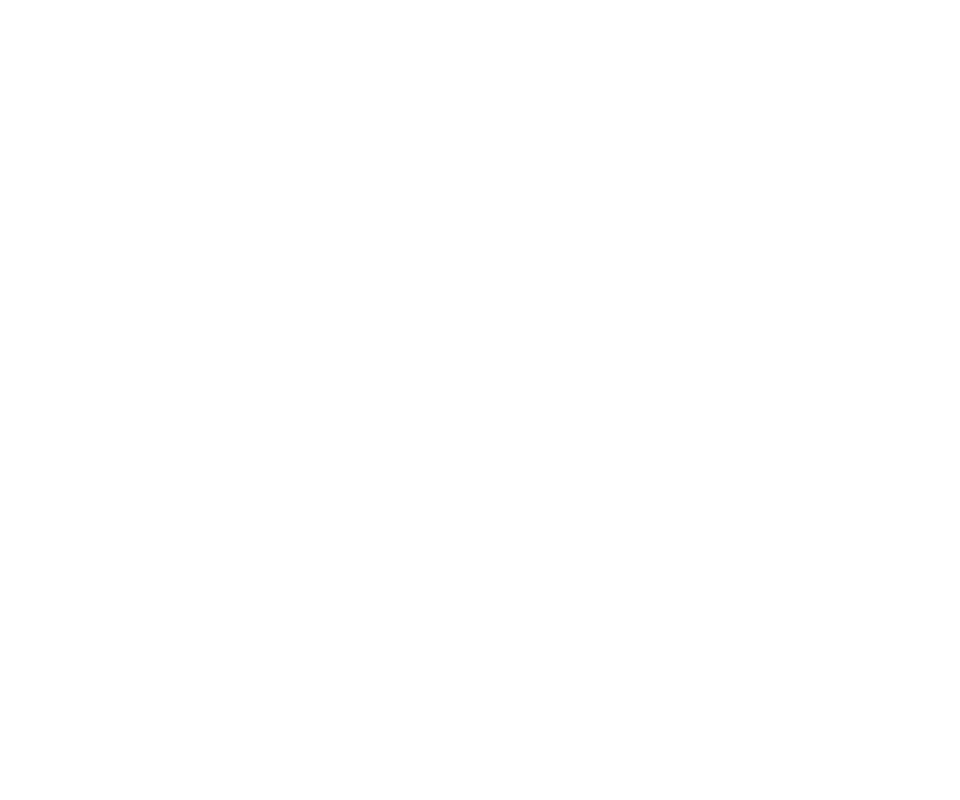

The fitted diffusion coefficient D0 is:  1.261e+05   A^2S-1
The fitted diffusion coefficient D0 is:  4.065e+04   A^2S-1
The fitted diffusion coefficient D0 is:  4.539e+04   A^2S-1


<IPython.core.display.Javascript object>


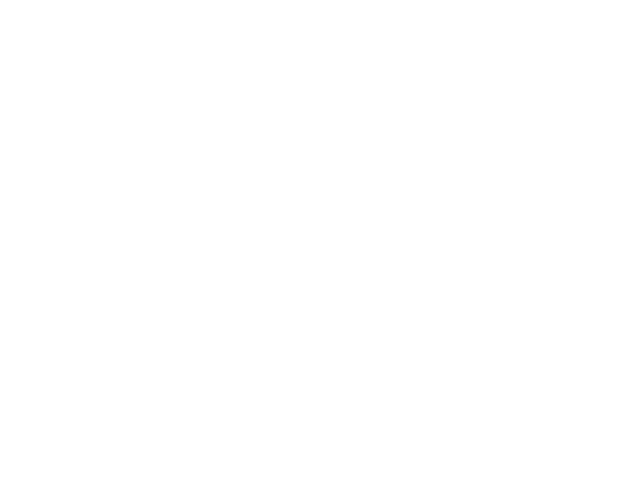

Averaging images:  26%|██▌       | 26/100 [00:00<00:00, 259.35it/s]

****************************************

The 1--th uid to be analyzed is : 5393006e-b981-44e4-ba78-b761c97a530d
hdf5 path = /XF11ID/data/2016/08/02/e54a019a-4e00-4405-a45d_3465_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_5393006e-b981-44e4-ba78-b761c97a530d.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 1135.25it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 16.57it/s]

G2 calculation DONE!
The correlation function of uid= 5393006e-b981-44e4-ba78-b761c97a530d is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/5393006e-b981-44e4-ba78-b761c97a530d/g2-5393006e-b981-44e4-ba78-b761c97a530d-20160916-1627-.csv


<IPython.core.display.Javascript object>


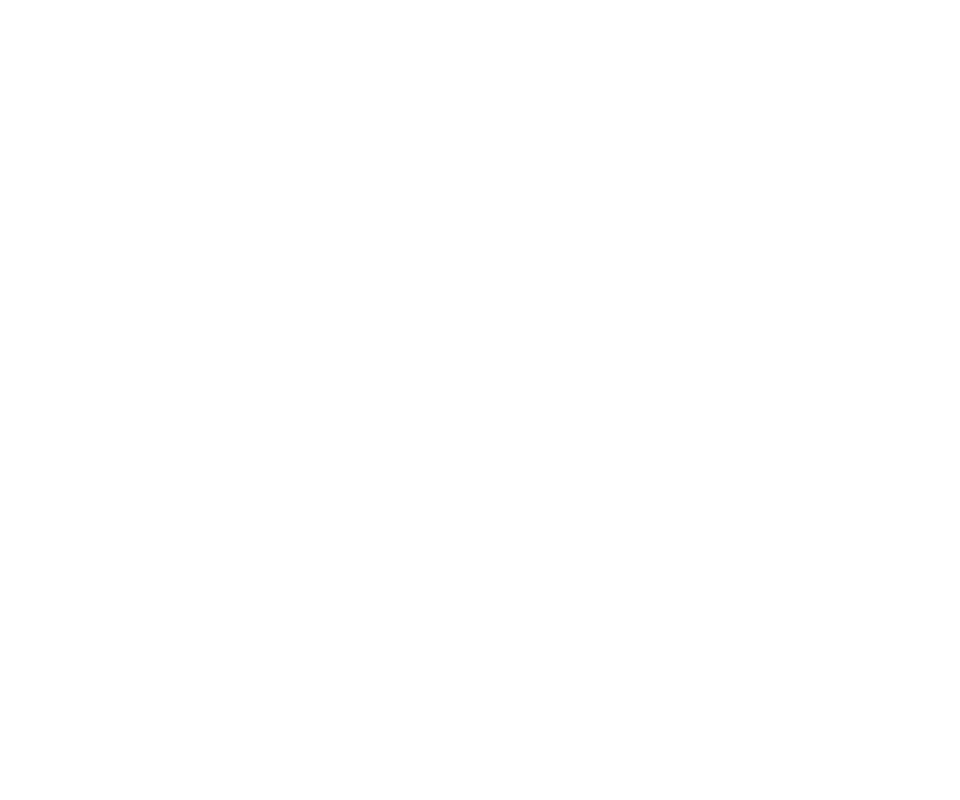

The fitted diffusion coefficient D0 is:  2.288e+04   A^2S-1
The fitted diffusion coefficient D0 is:  3.990e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.614e+04   A^2S-1


<IPython.core.display.Javascript object>


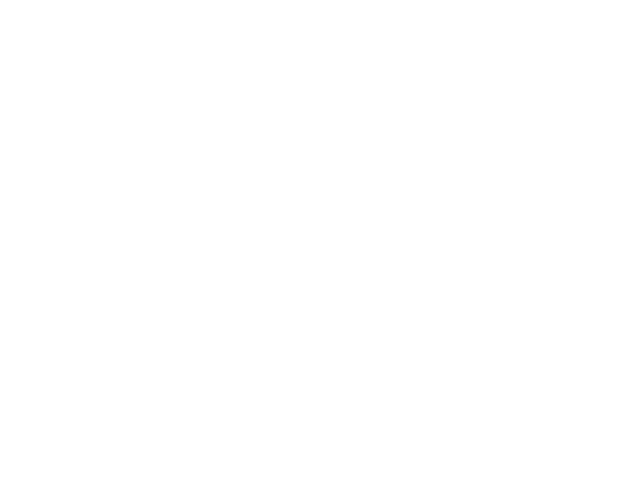

Averaging images:  19%|█▉        | 19/100 [00:00<00:00, 185.33it/s]

****************************************

The 2--th uid to be analyzed is : 1b1c2555-e0a7-49dd-8ac1-85a829df3276
hdf5 path = /XF11ID/data/2016/08/02/4d59c472-95b0-4ae6-b0b8_3466_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_1b1c2555-e0a7-49dd-8ac1-85a829df3276.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 1074.26it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 24.26it/s]

G2 calculation DONE!
The correlation function of uid= 1b1c2555-e0a7-49dd-8ac1-85a829df3276 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/1b1c2555-e0a7-49dd-8ac1-85a829df3276/g2-1b1c2555-e0a7-49dd-8ac1-85a829df3276-20160916-1627-.csv


<IPython.core.display.Javascript object>


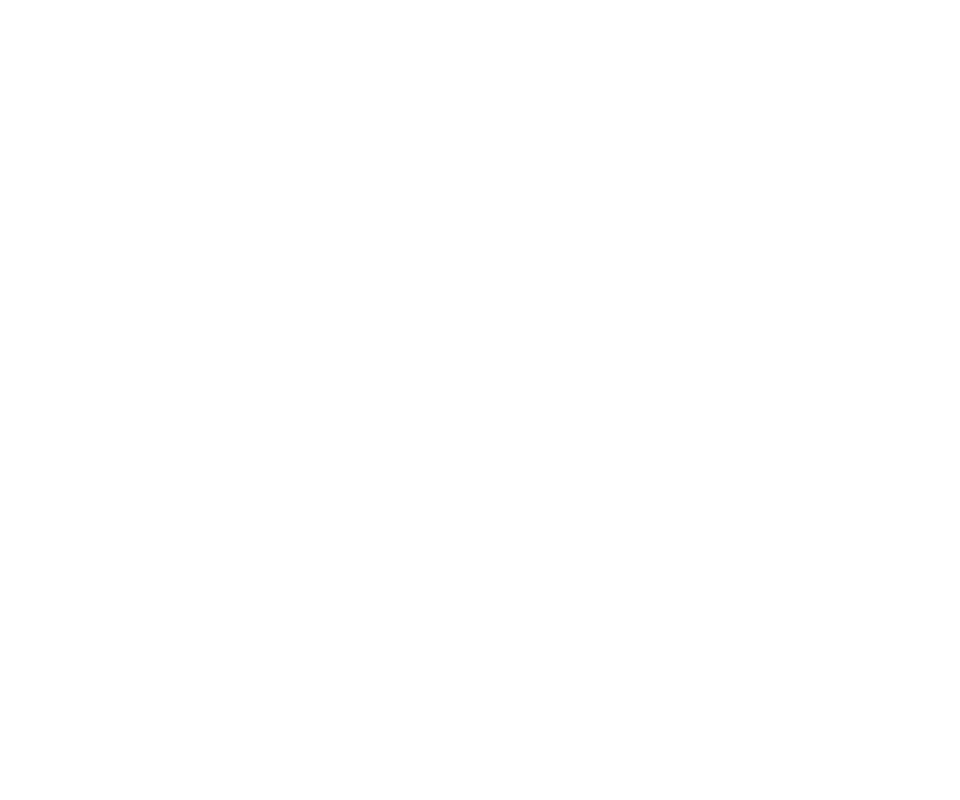

The fitted diffusion coefficient D0 is:  5.969e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.798e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.183e+04   A^2S-1


<IPython.core.display.Javascript object>


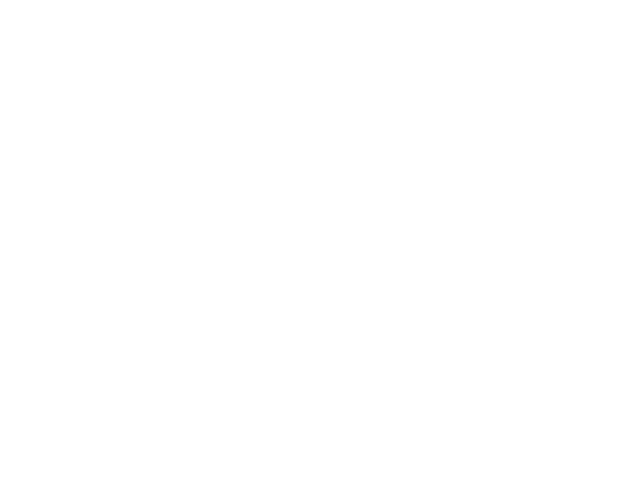

Averaging images:  21%|██        | 21/100 [00:00<00:00, 206.28it/s]

****************************************

The 3--th uid to be analyzed is : a332ec9c-4d5c-4769-b36a-b94778a031c3
hdf5 path = /XF11ID/data/2016/08/02/a63e0a9d-a61d-442e-94f1_3467_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a332ec9c-4d5c-4769-b36a-b94778a031c3.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 819.18it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 22.31it/s]

G2 calculation DONE!
The correlation function of uid= a332ec9c-4d5c-4769-b36a-b94778a031c3 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/a332ec9c-4d5c-4769-b36a-b94778a031c3/g2-a332ec9c-4d5c-4769-b36a-b94778a031c3-20160916-1627-.csv


<IPython.core.display.Javascript object>


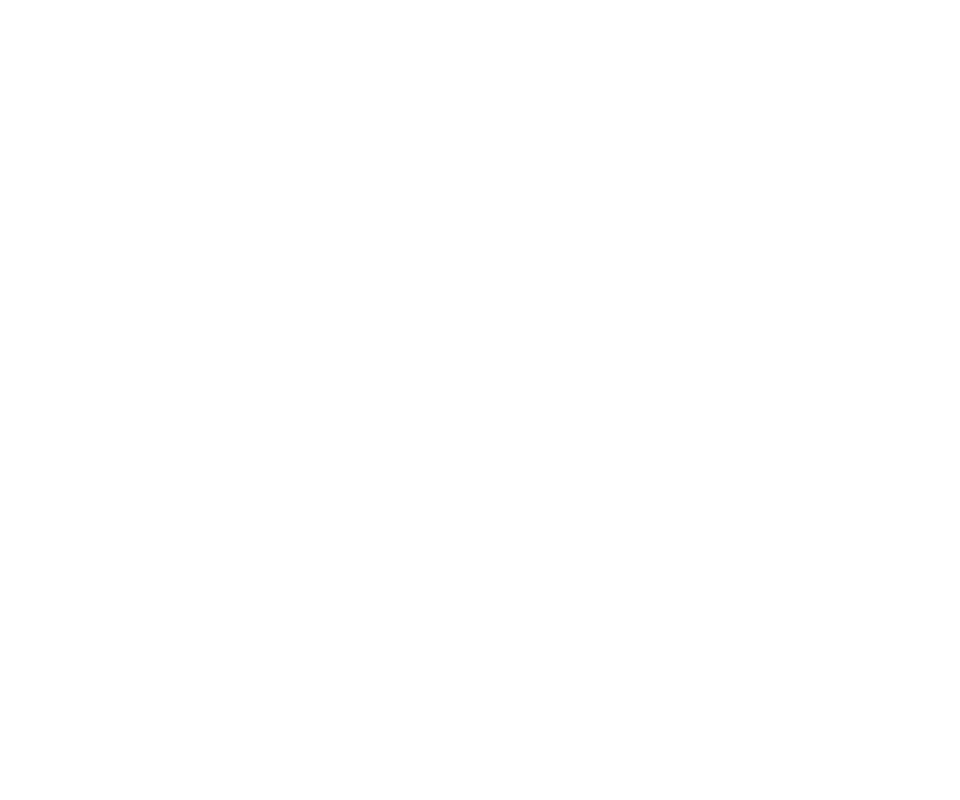

The fitted diffusion coefficient D0 is:  8.704e+04   A^2S-1
The fitted diffusion coefficient D0 is:  4.466e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.093e+04   A^2S-1


<IPython.core.display.Javascript object>


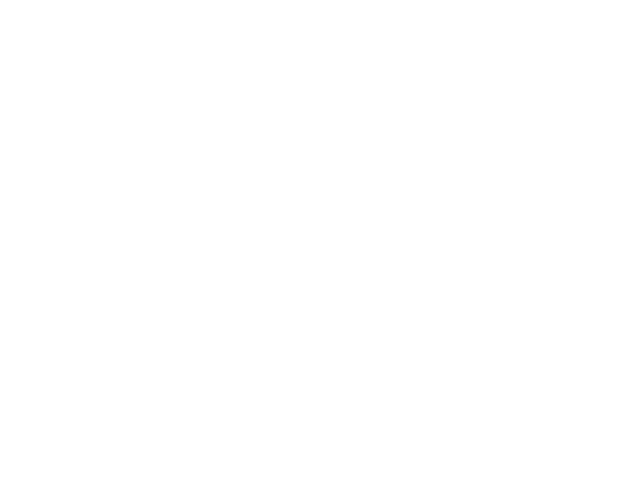

Averaging images:  23%|██▎       | 23/100 [00:00<00:00, 221.44it/s]

****************************************

The 4--th uid to be analyzed is : 98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f
hdf5 path = /XF11ID/data/2016/08/02/ff08d44e-ca52-45ba-a6c6_3468_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 865.21it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 20.64it/s]

G2 calculation DONE!
The correlation function of uid= 98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f/g2-98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f-20160916-1627-.csv


<IPython.core.display.Javascript object>


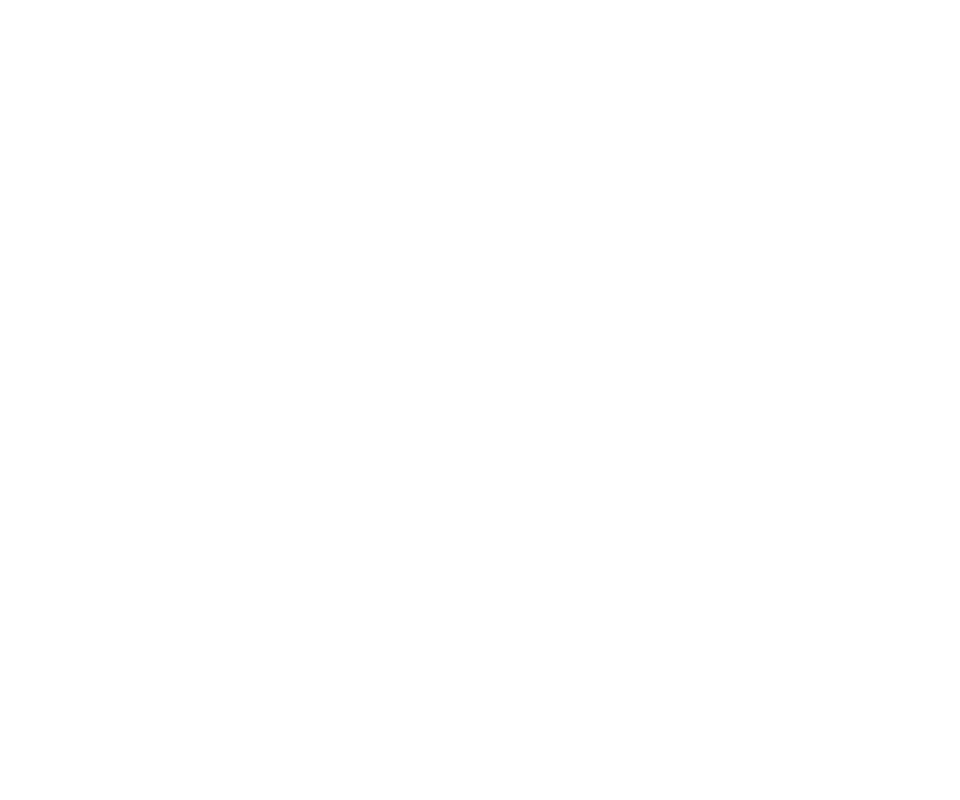

The fitted diffusion coefficient D0 is:  2.580e+05   A^2S-1
The fitted diffusion coefficient D0 is:  5.491e+03   A^2S-1
The fitted diffusion coefficient D0 is:  1.668e+05   A^2S-1


<IPython.core.display.Javascript object>


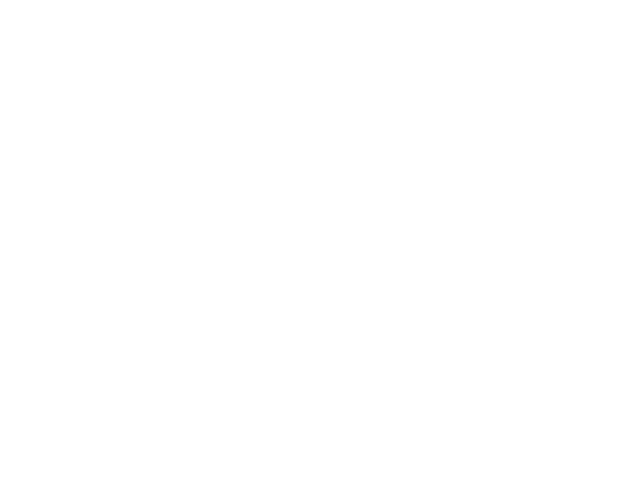

Averaging images:  20%|██        | 20/100 [00:00<00:00, 197.82it/s]

****************************************

The 5--th uid to be analyzed is : 91e3365b-e349-4e32-977e-3520313c4b5d
hdf5 path = /XF11ID/data/2016/08/02/5904dae2-215d-495e-bd67_3469_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_91e3365b-e349-4e32-977e-3520313c4b5d.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 872.38it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]

G2 calculation DONE!
The correlation function of uid= 91e3365b-e349-4e32-977e-3520313c4b5d is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/91e3365b-e349-4e32-977e-3520313c4b5d/g2-91e3365b-e349-4e32-977e-3520313c4b5d-20160916-1627-.csv


<IPython.core.display.Javascript object>


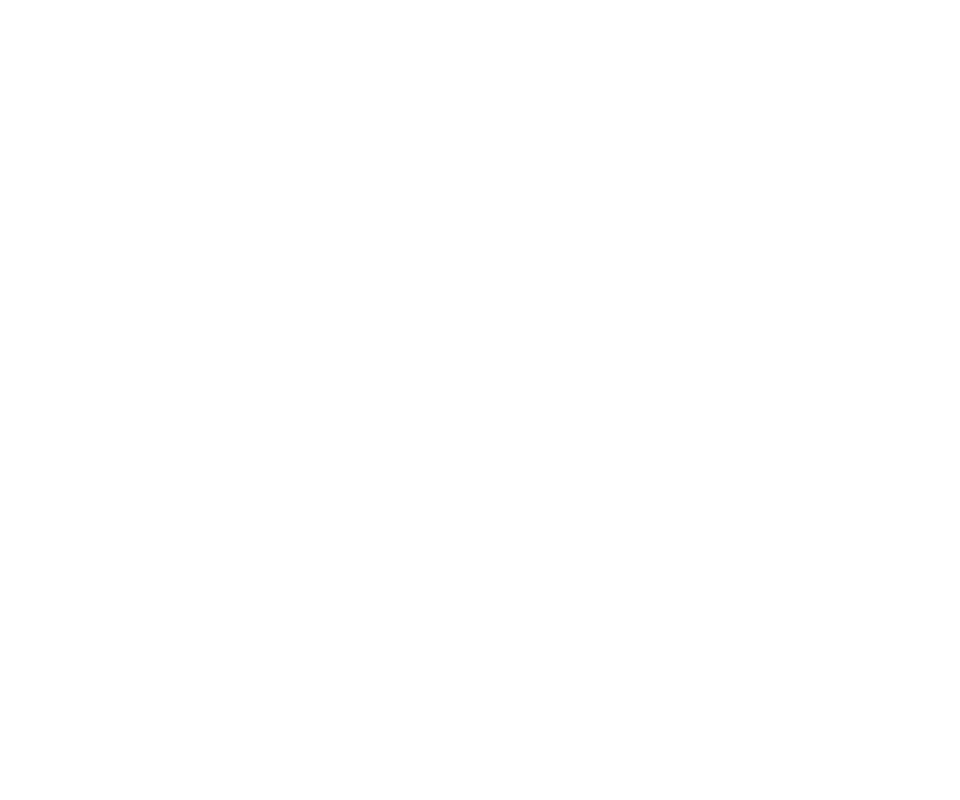

The fitted diffusion coefficient D0 is:  6.289e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.567e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.549e+05   A^2S-1


<IPython.core.display.Javascript object>


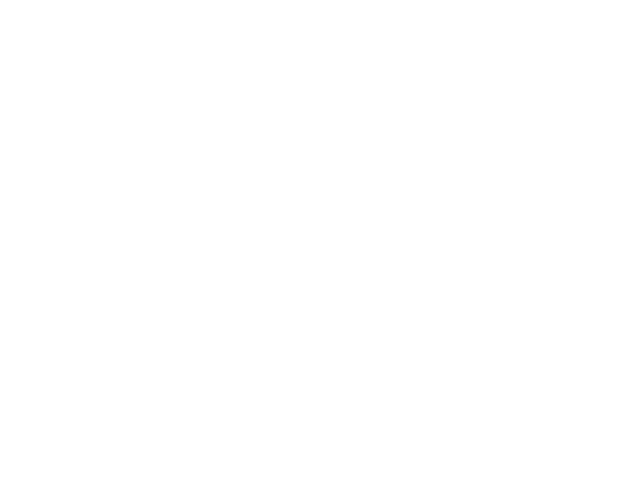

Averaging images:  48%|████▊     | 48/100 [00:00<00:00, 472.49it/s]

****************************************

The 6--th uid to be analyzed is : 562bb233-55e1-4e71-9978-3d98fcd2dc8b
hdf5 path = /XF11ID/data/2016/08/02/f1bc97dd-1b77-42b7-a235_3470_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_562bb233-55e1-4e71-9978-3d98fcd2dc8b.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:03<00:00, 25.59it/s]

G2 calculation DONE!
The correlation function of uid= 562bb233-55e1-4e71-9978-3d98fcd2dc8b is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/562bb233-55e1-4e71-9978-3d98fcd2dc8b/g2-562bb233-55e1-4e71-9978-3d98fcd2dc8b-20160916-1627-.csv


<IPython.core.display.Javascript object>


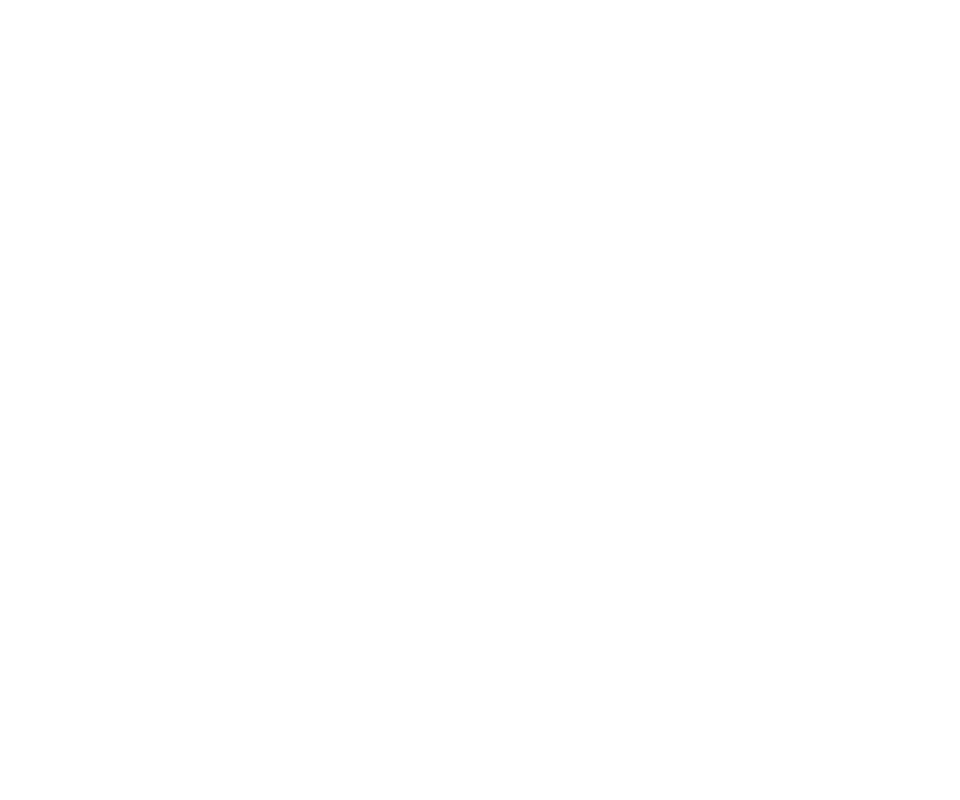

The fitted diffusion coefficient D0 is:  8.907e+03   A^2S-1
The fitted diffusion coefficient D0 is:  2.430e+05   A^2S-1
The fitted diffusion coefficient D0 is:  1.460e+04   A^2S-1


<IPython.core.display.Javascript object>


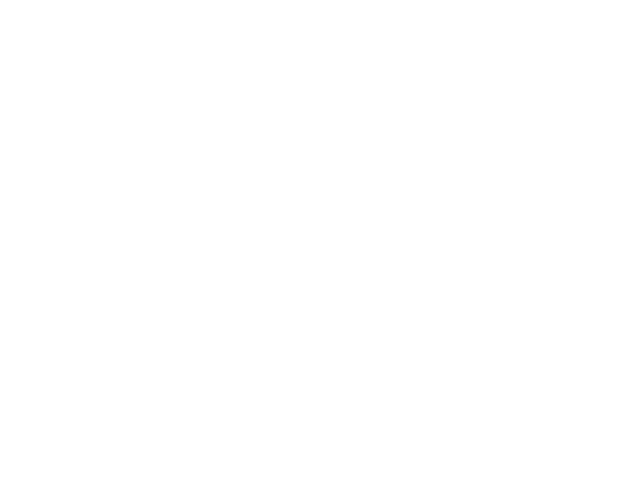

Averaging images:  53%|█████▎    | 53/100 [00:00<00:00, 527.79it/s]

****************************************

The 7--th uid to be analyzed is : 921403af-2c67-4008-8a9c-a12d57f6b049
hdf5 path = /XF11ID/data/2016/08/02/454d9e55-d7b1-437c-ad4a_3471_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_921403af-2c67-4008-8a9c-a12d57f6b049.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

Bad frame list length is: 2
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
98 frames will be processed...


100%|██████████| 100/100 [00:03<00:00, 26.67it/s]

G2 calculation DONE!
The correlation function of uid= 921403af-2c67-4008-8a9c-a12d57f6b049 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/921403af-2c67-4008-8a9c-a12d57f6b049/g2-921403af-2c67-4008-8a9c-a12d57f6b049-20160916-1628-.csv


<IPython.core.display.Javascript object>


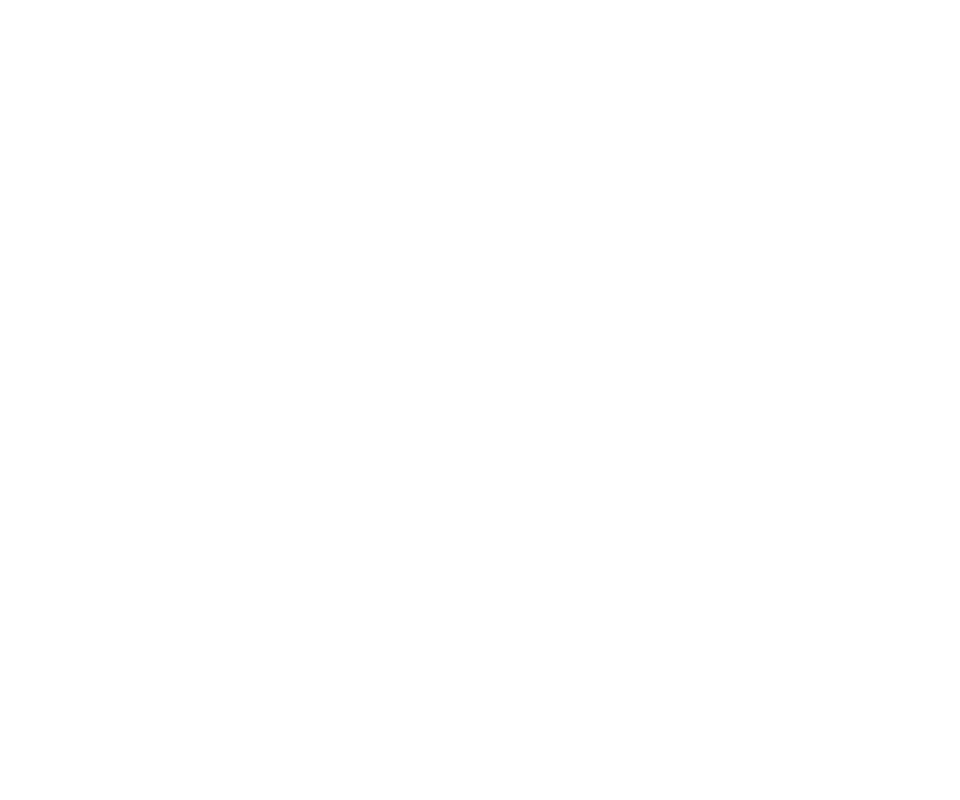

The fitted diffusion coefficient D0 is:  5.922e+03   A^2S-1
The fitted diffusion coefficient D0 is:  1.157e+05   A^2S-1
The fitted diffusion coefficient D0 is:  5.218e+03   A^2S-1


<IPython.core.display.Javascript object>


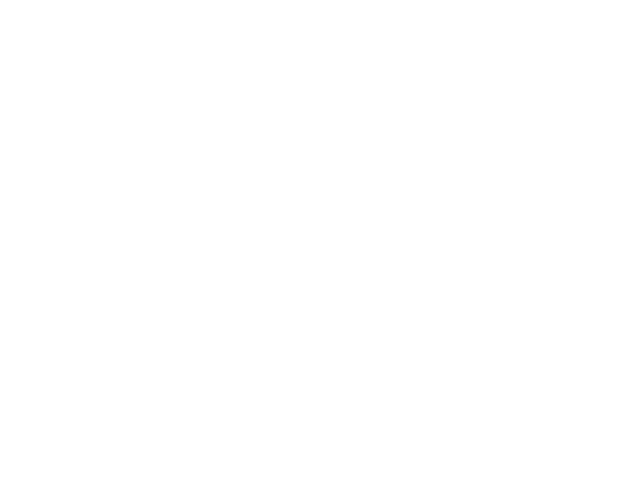

Averaging images:  63%|██████▎   | 63/100 [00:00<00:00, 622.99it/s]

****************************************

The 8--th uid to be analyzed is : b6e70033-0e93-41ca-acfa-4dd214082953
hdf5 path = /XF11ID/data/2016/08/02/ee1d7ea3-cfdd-4db7-b8c3_3472_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_b6e70033-0e93-41ca-acfa-4dd214082953.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

Bad frame list length is: 4
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
96 frames will be processed...


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]

G2 calculation DONE!
The correlation function of uid= b6e70033-0e93-41ca-acfa-4dd214082953 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/b6e70033-0e93-41ca-acfa-4dd214082953/g2-b6e70033-0e93-41ca-acfa-4dd214082953-20160916-1628-.csv


<IPython.core.display.Javascript object>


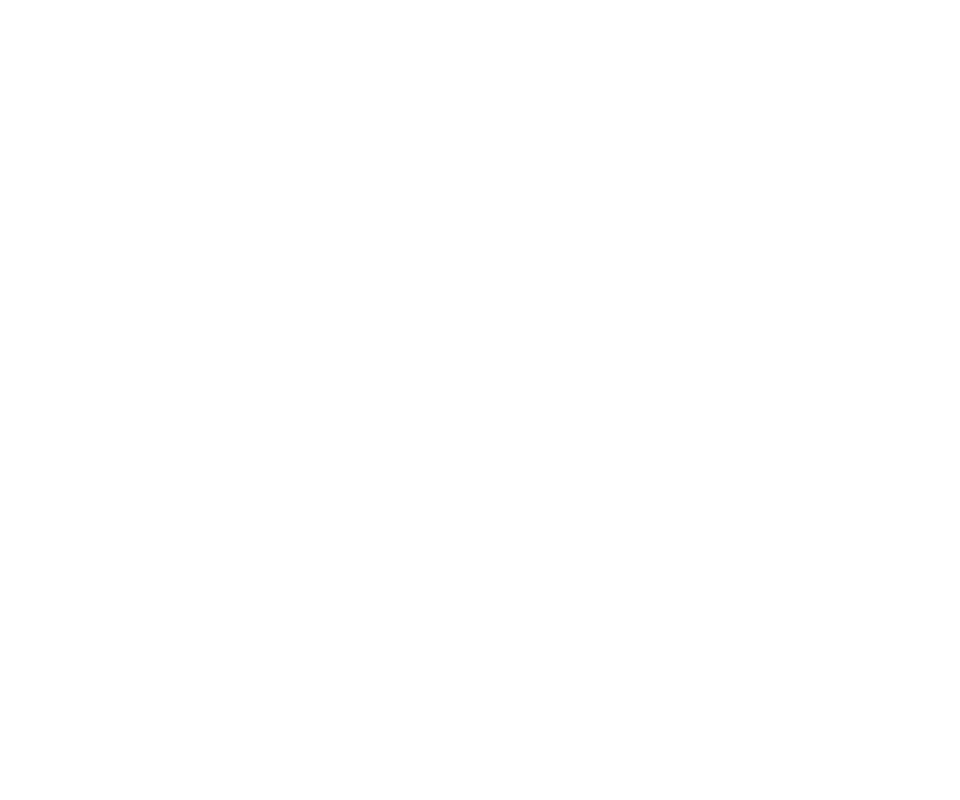

The fitted diffusion coefficient D0 is:  3.434e+04   A^2S-1
The fitted diffusion coefficient D0 is:  3.449e+05   A^2S-1
The fitted diffusion coefficient D0 is:  1.071e+04   A^2S-1


<IPython.core.display.Javascript object>


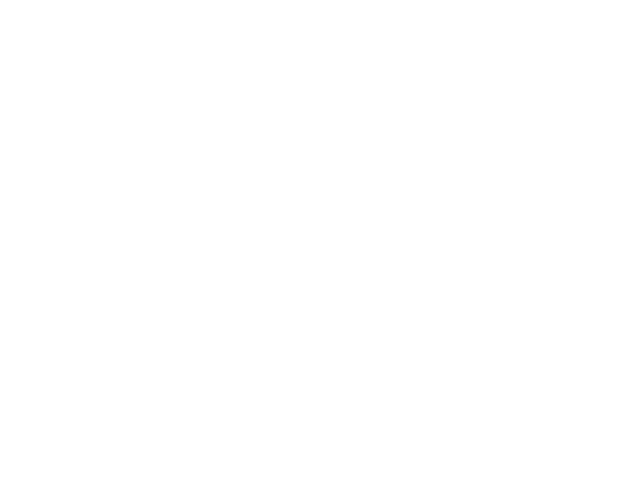

Averaging images:  22%|██▏       | 22/100 [00:00<00:00, 213.15it/s]

****************************************

The 9--th uid to be analyzed is : bc60dfda-2523-4c00-8f66-be10aaa08bcb
hdf5 path = /XF11ID/data/2016/08/02/a674b21d-b141-438d-8019_3473_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_bc60dfda-2523-4c00-8f66-be10aaa08bcb.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 793.63it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 22.21it/s]

G2 calculation DONE!
The correlation function of uid= bc60dfda-2523-4c00-8f66-be10aaa08bcb is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/bc60dfda-2523-4c00-8f66-be10aaa08bcb/g2-bc60dfda-2523-4c00-8f66-be10aaa08bcb-20160916-1628-.csv


<IPython.core.display.Javascript object>


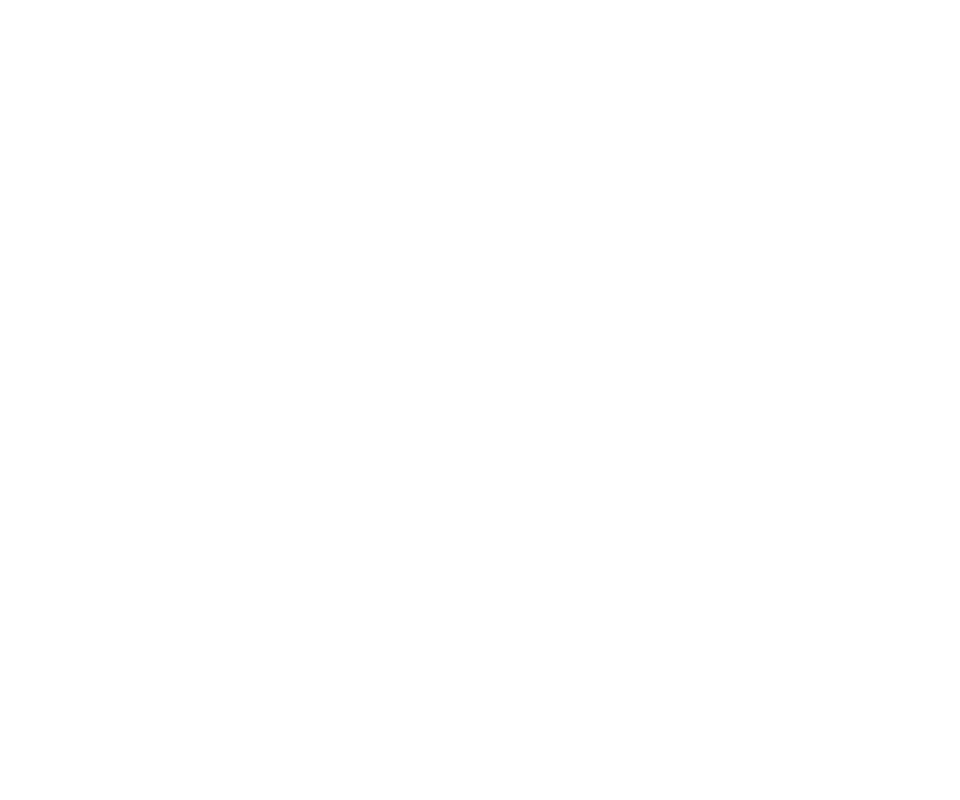

The fitted diffusion coefficient D0 is:  5.641e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.614e+05   A^2S-1
The fitted diffusion coefficient D0 is:  6.774e+04   A^2S-1


<IPython.core.display.Javascript object>


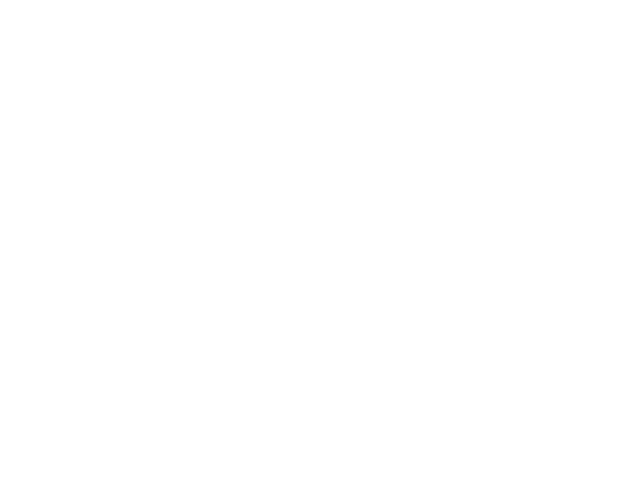

Averaging images:  43%|████▎     | 43/100 [00:00<00:00, 426.02it/s]

****************************************

The 10--th uid to be analyzed is : 86c43343-9856-4c06-805d-19c541d2e89a
hdf5 path = /XF11ID/data/2016/08/02/a1a3f362-5213-40c1-9448_3474_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_86c43343-9856-4c06-805d-19c541d2e89a.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:03<00:00, 25.47it/s]

G2 calculation DONE!
The correlation function of uid= 86c43343-9856-4c06-805d-19c541d2e89a is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/86c43343-9856-4c06-805d-19c541d2e89a/g2-86c43343-9856-4c06-805d-19c541d2e89a-20160916-1628-.csv


<IPython.core.display.Javascript object>


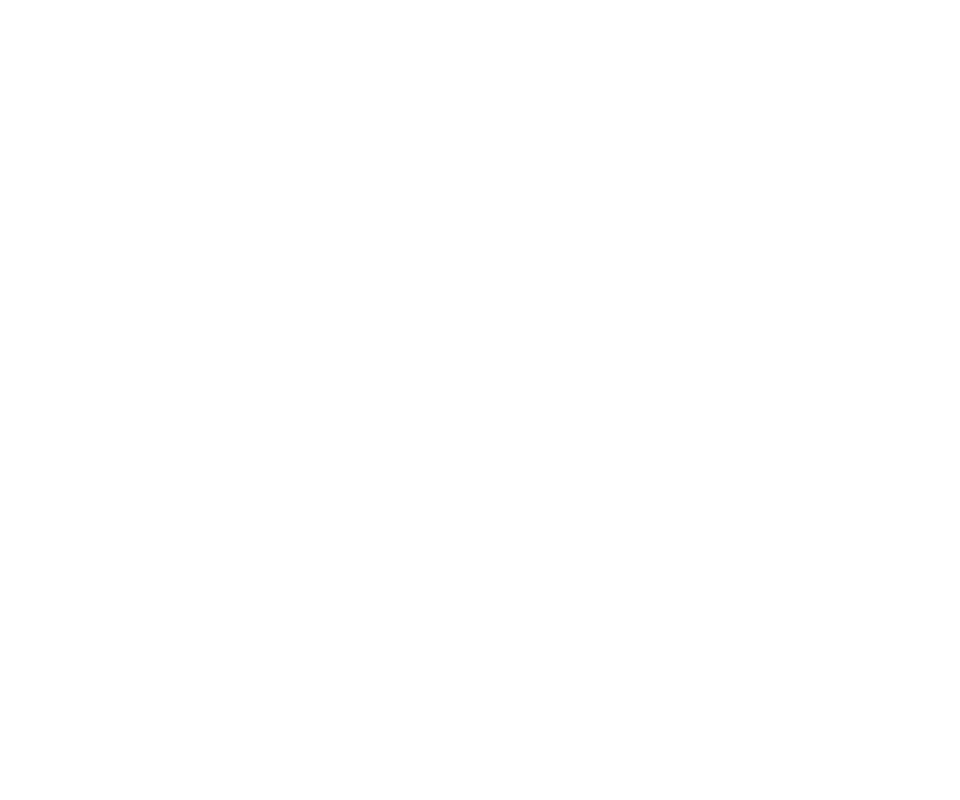

The fitted diffusion coefficient D0 is:  7.396e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.088e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.345e+05   A^2S-1


<IPython.core.display.Javascript object>


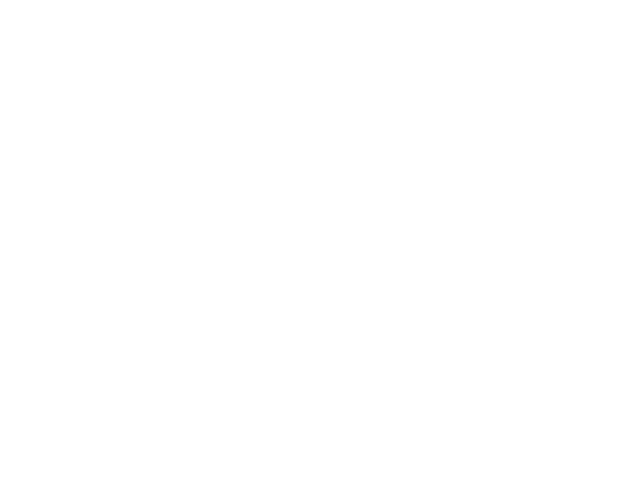

Averaging images:  49%|████▉     | 49/100 [00:00<00:00, 489.20it/s]

****************************************

The 11--th uid to be analyzed is : eda11800-5b00-4539-8be8-4237a4fdfbff
hdf5 path = /XF11ID/data/2016/08/02/ec779bc2-e200-4071-baac_3475_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_eda11800-5b00-4539-8be8-4237a4fdfbff.cmp.


  0%|          | 0/99 [00:00<?, ?it/s]

Bad frame list length is: 2
With compression, the good_start frame number is: 1 
In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
98 frames will be processed...


100%|██████████| 99/99 [00:03<00:00, 25.63it/s]

G2 calculation DONE!
The correlation function of uid= eda11800-5b00-4539-8be8-4237a4fdfbff is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/eda11800-5b00-4539-8be8-4237a4fdfbff/g2-eda11800-5b00-4539-8be8-4237a4fdfbff-20160916-1628-.csv


<IPython.core.display.Javascript object>


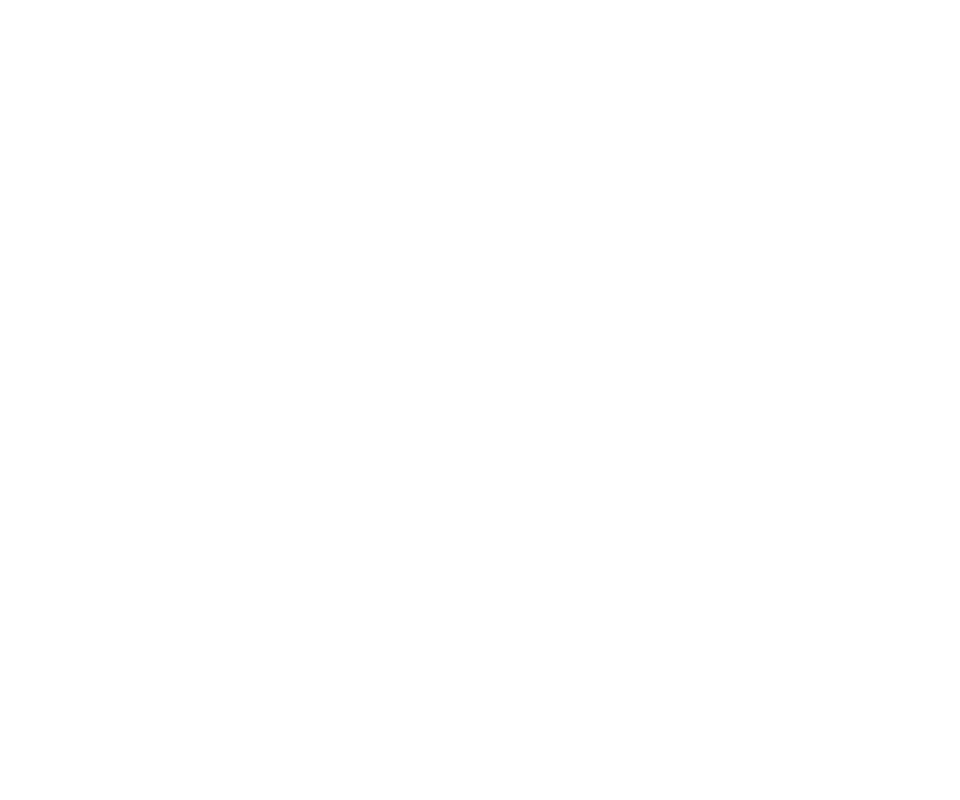

The fitted diffusion coefficient D0 is:  1.716e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.843e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.394e+04   A^2S-1


<IPython.core.display.Javascript object>


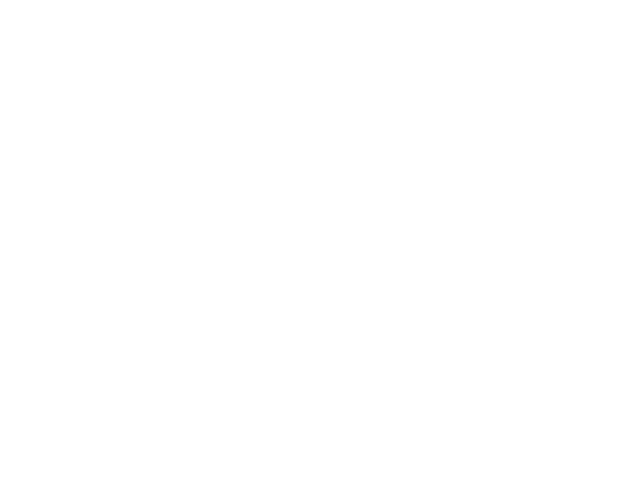

Averaging images:  58%|█████▊    | 58/100 [00:00<00:00, 578.11it/s]

****************************************

The 12--th uid to be analyzed is : 446bbdd6-617c-4fc4-9cab-3abdf233e195
hdf5 path = /XF11ID/data/2016/08/02/d9d6b4a1-c4ed-46f5-a8a6_3476_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_446bbdd6-617c-4fc4-9cab-3abdf233e195.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

Bad frame list length is: 2
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
98 frames will be processed...


100%|██████████| 100/100 [00:03<00:00, 22.28it/s]

G2 calculation DONE!
The correlation function of uid= 446bbdd6-617c-4fc4-9cab-3abdf233e195 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/446bbdd6-617c-4fc4-9cab-3abdf233e195/g2-446bbdd6-617c-4fc4-9cab-3abdf233e195-20160916-1628-.csv


<IPython.core.display.Javascript object>


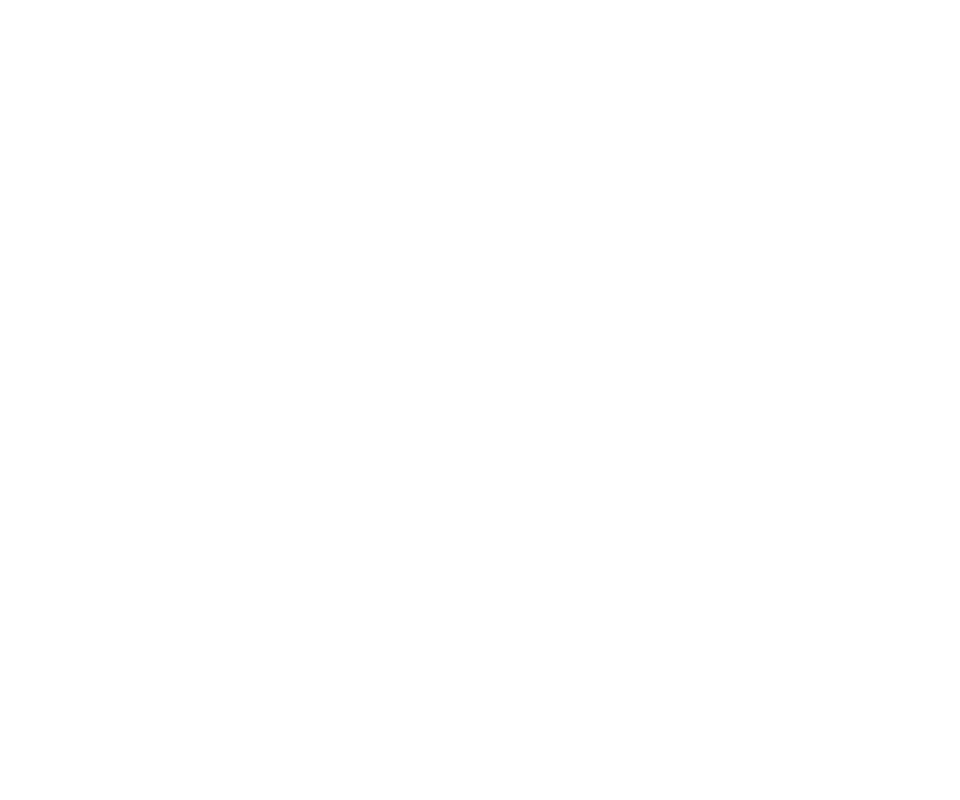

The fitted diffusion coefficient D0 is:  2.726e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.928e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.956e+04   A^2S-1


<IPython.core.display.Javascript object>


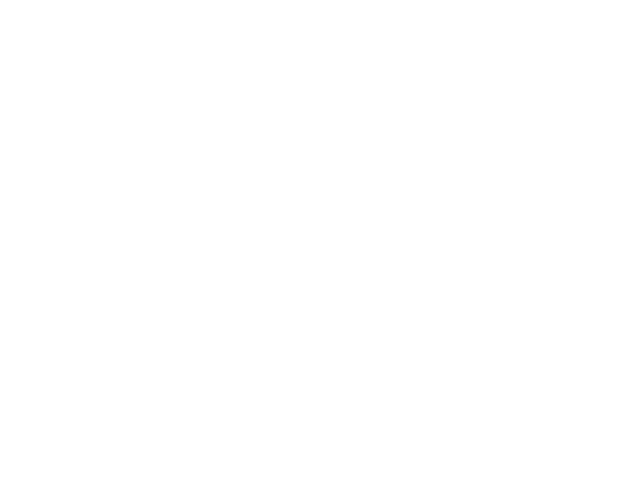

Averaging images:  25%|██▌       | 25/100 [00:00<00:00, 243.83it/s]

****************************************

The 13--th uid to be analyzed is : 0c56f77b-59c9-40f2-9516-47c9aa657c5d
hdf5 path = /XF11ID/data/2016/08/02/0177c34b-ddf1-4bcd-a458_3477_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_0c56f77b-59c9-40f2-9516-47c9aa657c5d.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 1447.07it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 24.37it/s]

G2 calculation DONE!
The correlation function of uid= 0c56f77b-59c9-40f2-9516-47c9aa657c5d is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/0c56f77b-59c9-40f2-9516-47c9aa657c5d/g2-0c56f77b-59c9-40f2-9516-47c9aa657c5d-20160916-1628-.csv


<IPython.core.display.Javascript object>


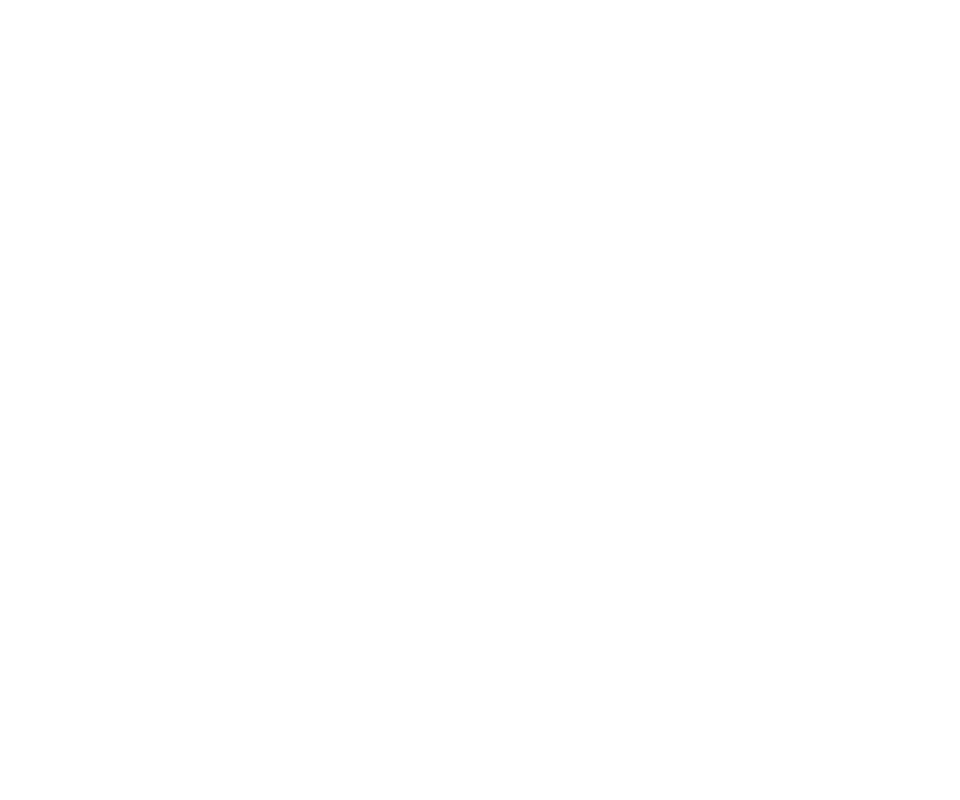

The fitted diffusion coefficient D0 is:  5.302e+03   A^2S-1
The fitted diffusion coefficient D0 is:  1.028e+05   A^2S-1
The fitted diffusion coefficient D0 is:  7.168e+04   A^2S-1


<IPython.core.display.Javascript object>


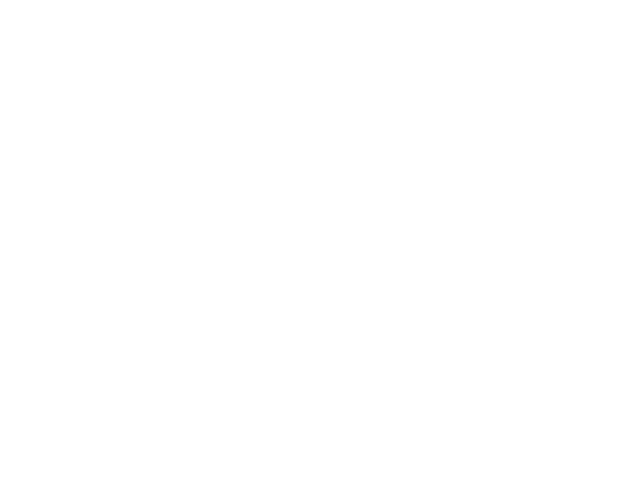

Averaging images:  39%|███▉      | 39/100 [00:00<00:00, 388.54it/s]

****************************************

The 14--th uid to be analyzed is : 841c0614-0e59-41db-b1e7-fbb66eae2dcd
hdf5 path = /XF11ID/data/2016/08/02/82735694-280b-4481-8047_3478_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_841c0614-0e59-41db-b1e7-fbb66eae2dcd.cmp.


  0%|          | 0/100 [00:00<?, ?it/s]

No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 22.10it/s]

G2 calculation DONE!
The correlation function of uid= 841c0614-0e59-41db-b1e7-fbb66eae2dcd is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/841c0614-0e59-41db-b1e7-fbb66eae2dcd/g2-841c0614-0e59-41db-b1e7-fbb66eae2dcd-20160916-1629-.csv


<IPython.core.display.Javascript object>


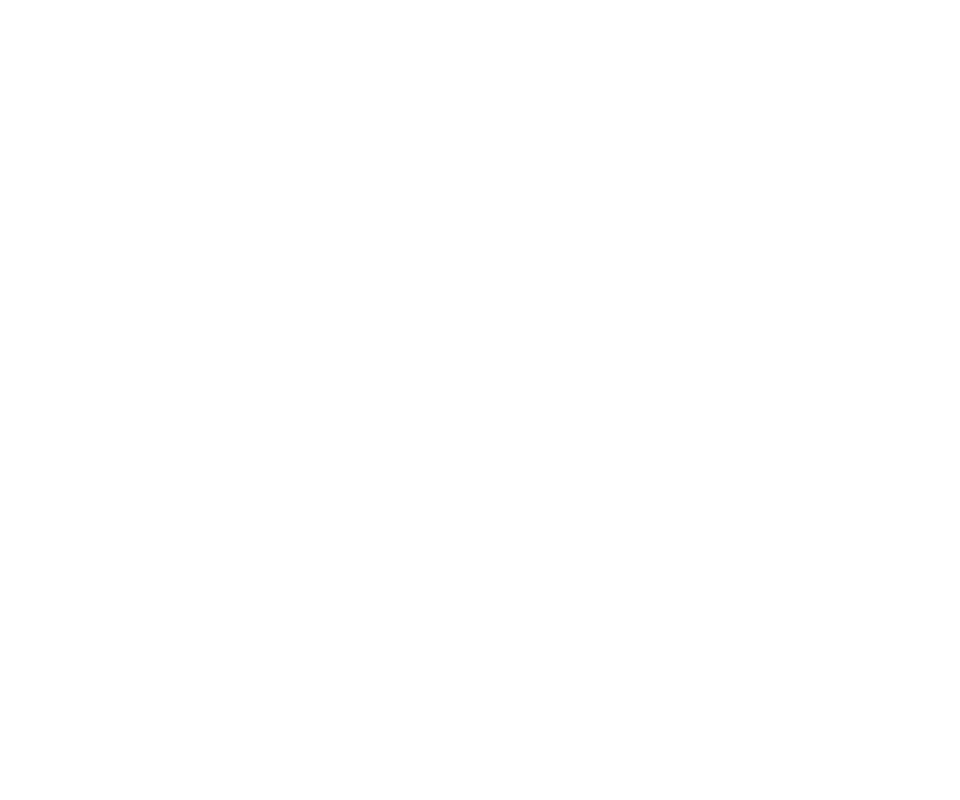

The fitted diffusion coefficient D0 is:  8.187e+03   A^2S-1
The fitted diffusion coefficient D0 is:  2.708e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.263e+05   A^2S-1


<IPython.core.display.Javascript object>


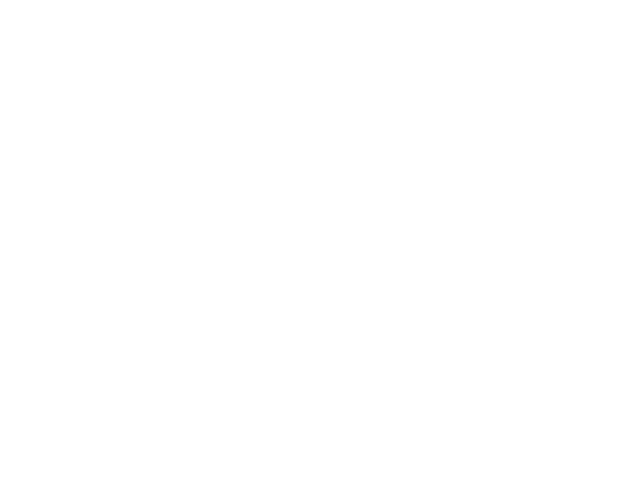

Averaging images:  16%|█▌        | 16/100 [00:00<00:00, 156.47it/s]

****************************************

The 15--th uid to be analyzed is : 2d7580df-893b-4998-8222-c31d4ab8b01d
hdf5 path = /XF11ID/data/2016/08/02/3b75a7f9-4b45-433a-96a2_3479_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_2d7580df-893b-4998-8222-c31d4ab8b01d.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 764.18it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:05<00:00, 18.40it/s]

G2 calculation DONE!
The correlation function of uid= 2d7580df-893b-4998-8222-c31d4ab8b01d is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/2d7580df-893b-4998-8222-c31d4ab8b01d/g2-2d7580df-893b-4998-8222-c31d4ab8b01d-20160916-1629-.csv


<IPython.core.display.Javascript object>


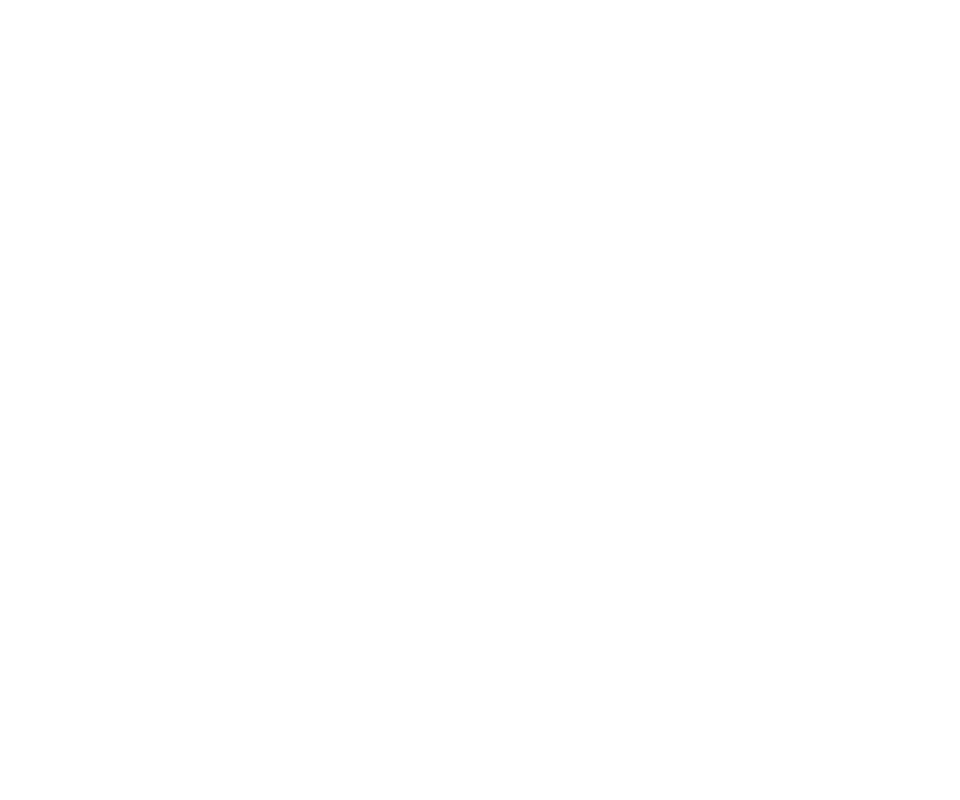

The fitted diffusion coefficient D0 is:  9.604e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.650e+05   A^2S-1
The fitted diffusion coefficient D0 is:  9.579e+04   A^2S-1


<IPython.core.display.Javascript object>


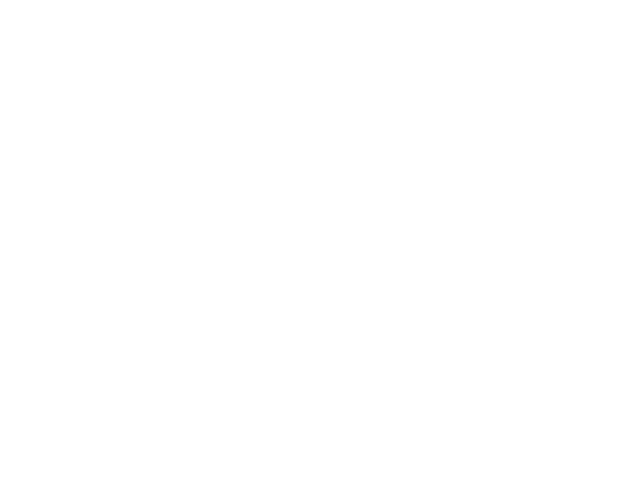

Averaging images:  18%|█▊        | 18/100 [00:00<00:00, 175.25it/s]

****************************************

The 16--th uid to be analyzed is : c744b447-f356-45ed-b4fc-88363e7ab13a
hdf5 path = /XF11ID/data/2016/08/02/d4d13048-e1ff-4a06-a346_3480_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_c744b447-f356-45ed-b4fc-88363e7ab13a.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 819.08it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:06<00:00, 20.86it/s]

G2 calculation DONE!
The correlation function of uid= c744b447-f356-45ed-b4fc-88363e7ab13a is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/c744b447-f356-45ed-b4fc-88363e7ab13a/g2-c744b447-f356-45ed-b4fc-88363e7ab13a-20160916-1629-.csv


<IPython.core.display.Javascript object>


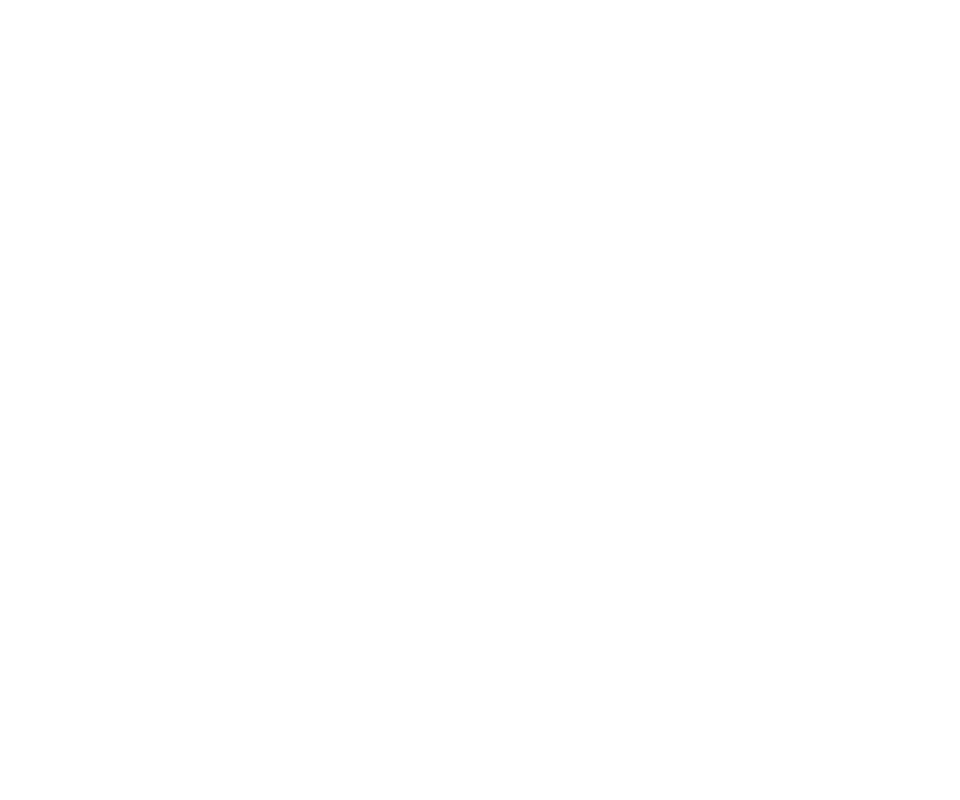

The fitted diffusion coefficient D0 is:  1.519e+04   A^2S-1
The fitted diffusion coefficient D0 is:  1.198e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.201e+05   A^2S-1


<IPython.core.display.Javascript object>


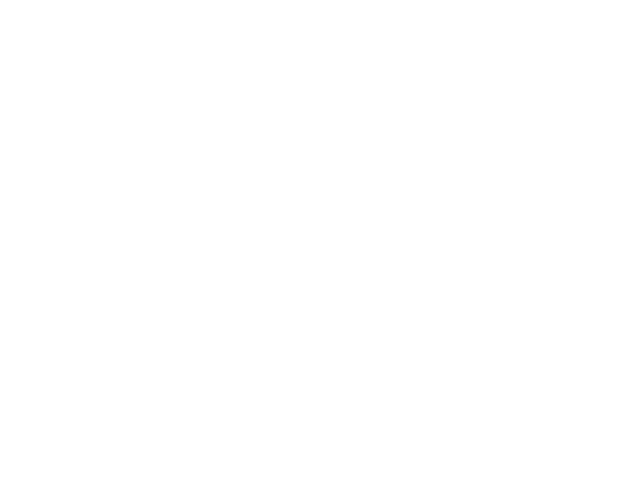

Averaging images:  29%|██▉       | 29/100 [00:00<00:00, 275.77it/s]

****************************************

The 17--th uid to be analyzed is : 14aa5cdf-8d24-434f-adf5-8bfc03040e14
hdf5 path = /XF11ID/data/2016/08/02/071702c1-b08c-499d-84a0_3481_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_14aa5cdf-8d24-434f-adf5-8bfc03040e14.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 911.81it/s]


Bad frame list length is: 2
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
Bad frame involved and will be precessed!
98 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 20.90it/s]

G2 calculation DONE!
The correlation function of uid= 14aa5cdf-8d24-434f-adf5-8bfc03040e14 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/14aa5cdf-8d24-434f-adf5-8bfc03040e14/g2-14aa5cdf-8d24-434f-adf5-8bfc03040e14-20160916-1629-.csv


<IPython.core.display.Javascript object>


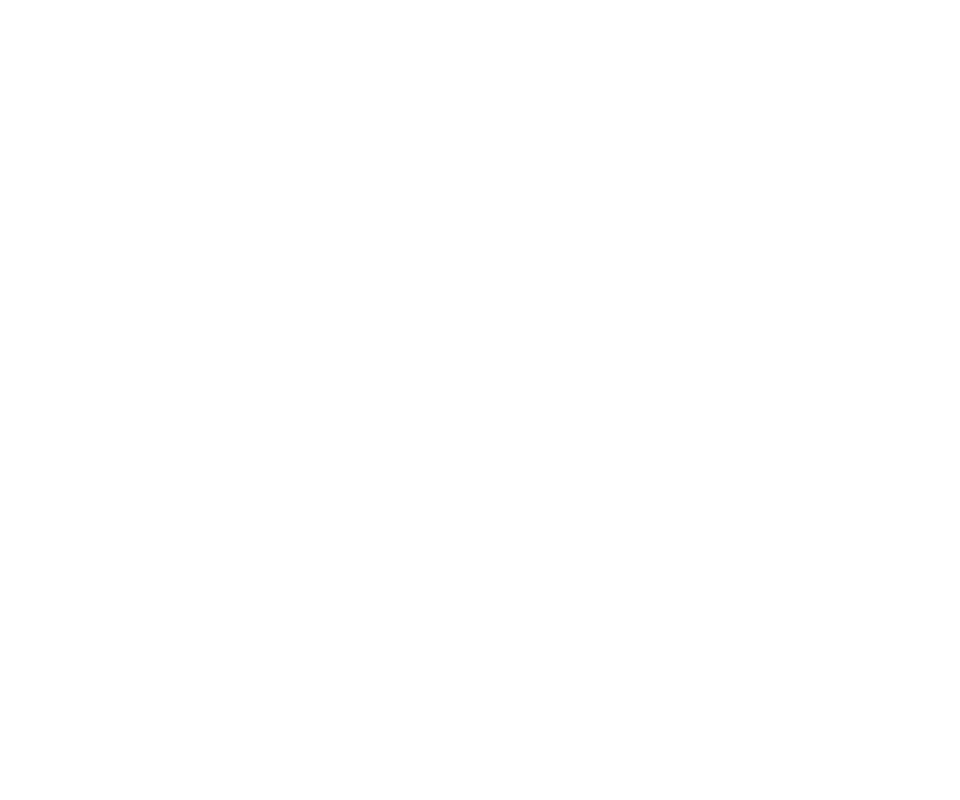

The fitted diffusion coefficient D0 is:  3.093e+05   A^2S-1
The fitted diffusion coefficient D0 is:  3.487e+05   A^2S-1
The fitted diffusion coefficient D0 is:  1.973e+05   A^2S-1


<IPython.core.display.Javascript object>


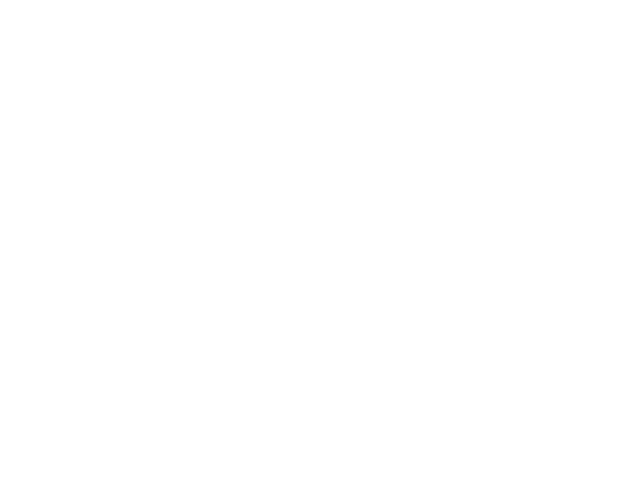

Averaging images:  33%|███▎      | 33/100 [00:00<00:00, 320.25it/s]

****************************************

The 18--th uid to be analyzed is : 2c0a9932-d147-41f7-9c8b-84dc8afe46ce
hdf5 path = /XF11ID/data/2016/08/02/a17323ef-4ebd-481c-9d4b_3482_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_2c0a9932-d147-41f7-9c8b-84dc8afe46ce.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 798.71it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 21.81it/s]

G2 calculation DONE!
The correlation function of uid= 2c0a9932-d147-41f7-9c8b-84dc8afe46ce is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/2c0a9932-d147-41f7-9c8b-84dc8afe46ce/g2-2c0a9932-d147-41f7-9c8b-84dc8afe46ce-20160916-1629-.csv


<IPython.core.display.Javascript object>


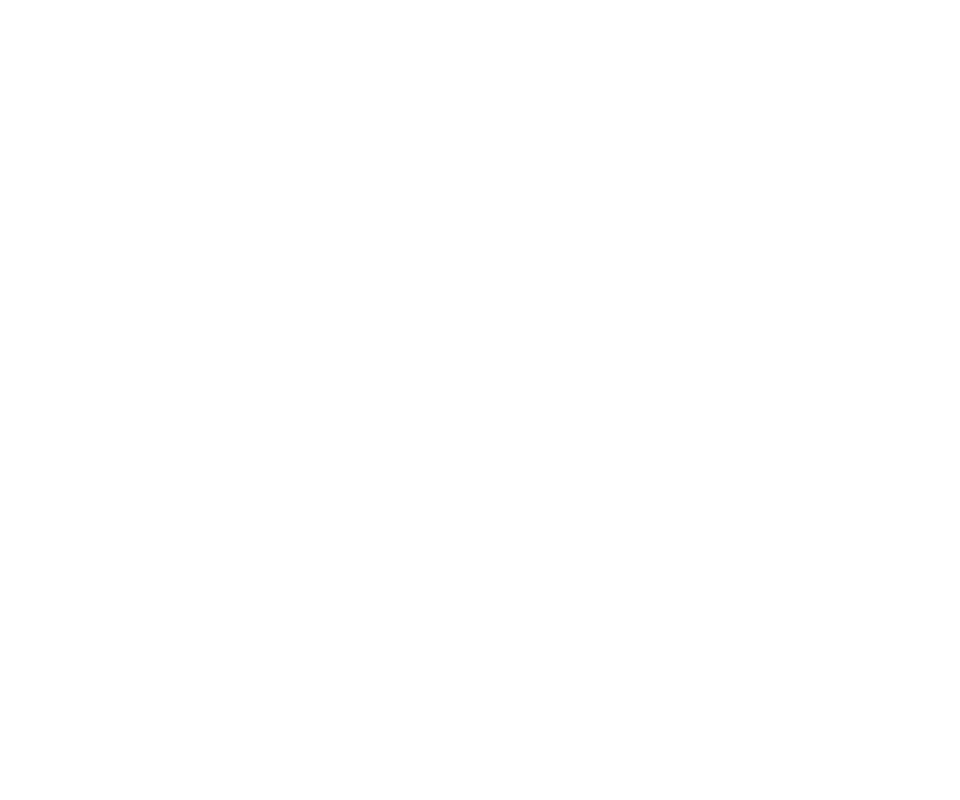

The fitted diffusion coefficient D0 is:  1.789e+05   A^2S-1
The fitted diffusion coefficient D0 is:  4.782e+05   A^2S-1
The fitted diffusion coefficient D0 is:  6.722e+04   A^2S-1


<IPython.core.display.Javascript object>


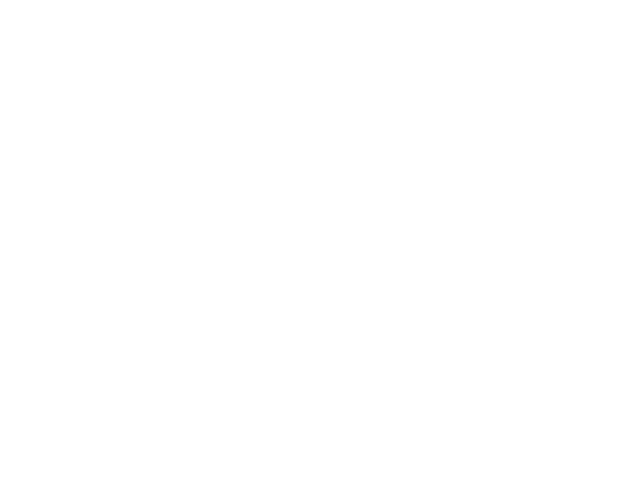

Averaging images:  23%|██▎       | 23/100 [00:00<00:00, 226.61it/s]

****************************************

The 19--th uid to be analyzed is : 97ce2ec2-c3bb-47e7-abe9-ede08c01183c
hdf5 path = /XF11ID/data/2016/08/02/b11421b7-fc57-46ce-8cab_3483_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_97ce2ec2-c3bb-47e7-abe9-ede08c01183c.cmp.


Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 829.73it/s]


No bad frames are involved.
With compression, the good_start frame number is: 0 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:04<00:00, 22.43it/s]

G2 calculation DONE!
The correlation function of uid= 97ce2ec2-c3bb-47e7-abe9-ede08c01183c is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/97ce2ec2-c3bb-47e7-abe9-ede08c01183c/g2-97ce2ec2-c3bb-47e7-abe9-ede08c01183c-20160916-1630-.csv


<IPython.core.display.Javascript object>


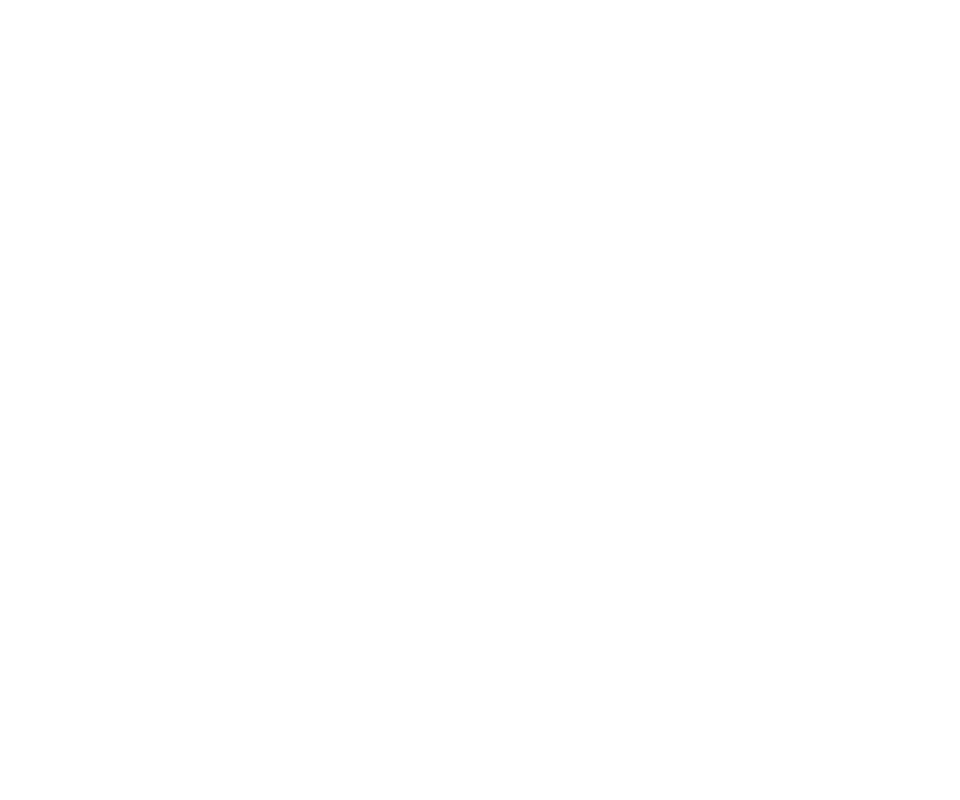

The fitted diffusion coefficient D0 is:  1.172e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.551e+05   A^2S-1
The fitted diffusion coefficient D0 is:  2.703e+04   A^2S-1


<IPython.core.display.Javascript object>


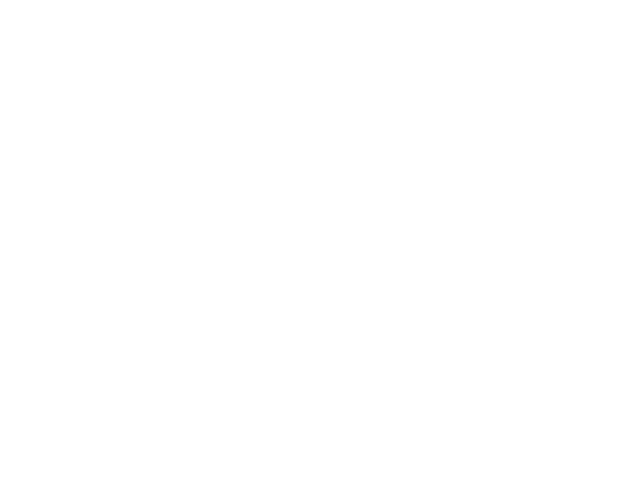

****************************************



In [36]:
g2s, taus, useful_uids  = multi_uids_gisaxs_xpcs_analysis(  
                    uids, md, run_num, sub_num, fit= True, compress=True  )


## Create PDF report for each uid

In [37]:
useful_uids

{1: {1: 'ac6a0483-dea7-48c4-b8dd-7c5bff73d675',
  2: '5393006e-b981-44e4-ba78-b761c97a530d',
  3: '1b1c2555-e0a7-49dd-8ac1-85a829df3276',
  4: 'a332ec9c-4d5c-4769-b36a-b94778a031c3',
  5: '98de9f2c-e8ef-4c4f-8ac4-cf7b67869c4f',
  6: '91e3365b-e349-4e32-977e-3520313c4b5d',
  7: '562bb233-55e1-4e71-9978-3d98fcd2dc8b',
  8: '921403af-2c67-4008-8a9c-a12d57f6b049',
  9: 'b6e70033-0e93-41ca-acfa-4dd214082953',
  10: 'bc60dfda-2523-4c00-8f66-be10aaa08bcb',
  11: '86c43343-9856-4c06-805d-19c541d2e89a',
  12: 'eda11800-5b00-4539-8be8-4237a4fdfbff',
  13: '446bbdd6-617c-4fc4-9cab-3abdf233e195',
  14: '0c56f77b-59c9-40f2-9516-47c9aa657c5d',
  15: '841c0614-0e59-41db-b1e7-fbb66eae2dcd',
  16: '2d7580df-893b-4998-8222-c31d4ab8b01d',
  17: 'c744b447-f356-45ed-b4fc-88363e7ab13a',
  18: '14aa5cdf-8d24-434f-adf5-8bfc03040e14',
  19: '2c0a9932-d147-41f7-9c8b-84dc8afe46ce',
  20: '97ce2ec2-c3bb-47e7-abe9-ede08c01183c'}}

* Create multi PDF report for each uid

In [38]:
#create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir )

## Create one PDF including all uids

In [48]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_, report_type='gisaxs' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/XPCS_Analysis_Report_for_uid=PEO39k_Aug02.pdf
****************************************


# Do average Here

In [40]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            g2s_average[key] +=  g2s[key][sub_key]
            i +=1
            print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
            #print( 'sub= %s,Doing average here'%sub_key)
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
Run= 1--sub_run= 5-- pass
Run= 1--sub_run= 6-- pass
Run= 1--sub_run= 7-- pass
sub= 8,Can not Doing average here
sub= 9,Can not Doing average here
Run= 1--sub_run= 10-- pass
Run= 1--sub_run= 11-- pass
sub= 12,Can not Doing average here
sub= 13,Can not Doing average here
Run= 1--sub_run= 14-- pass
Run= 1--sub_run= 15-- pass
Run= 1--sub_run= 16-- pass
Run= 1--sub_run= 17-- pass
sub= 18,Can not Doing average here
Run= 1--sub_run= 19-- pass
Run= 1--sub_run= 20-- pass


# Save Data

In [42]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                  path=data_dir, uid= 'Average@run-%s'%( key       ))
    save_gisaxs_g2(    g2s_average[key], res_pargs )


The correlation function of uid= Average@run-1 is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/g2-Average@run-1-20160916-1630-.csv


# Plot Avergaed Data

<IPython.core.display.Javascript object>


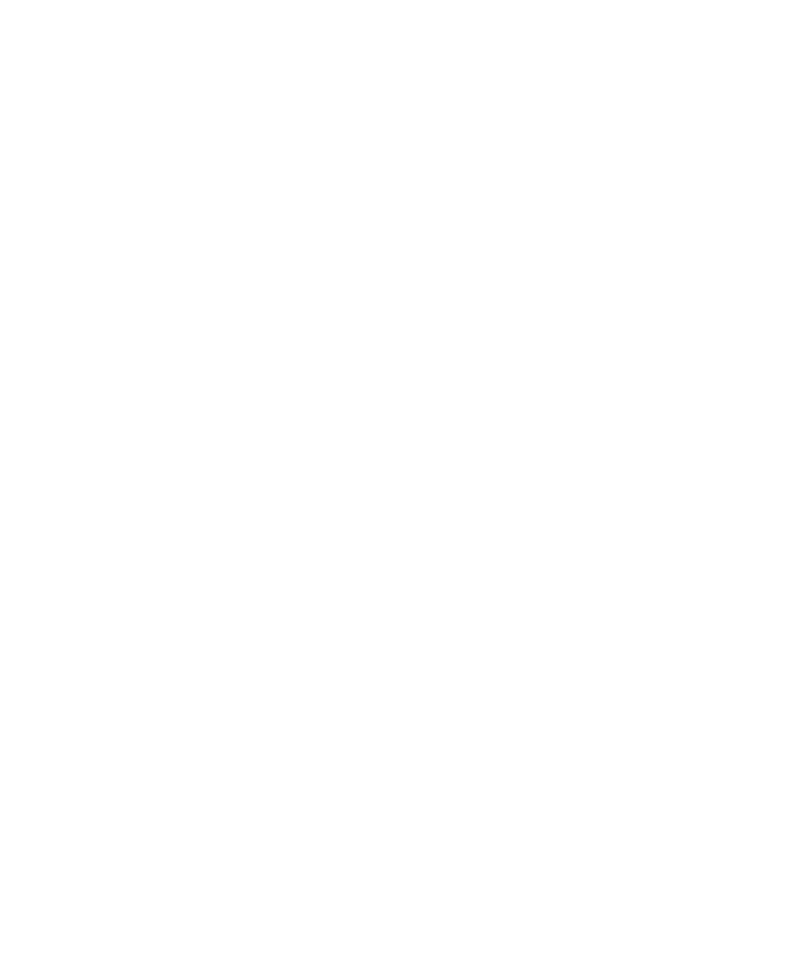

In [43]:
if True:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                      path=data_dir, uid= 'Average@run-%s'%( key       ))
        plot_gisaxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.15], res_pargs=res_pargs, one_plot=True)    

# Fit Avergaed Data

In [44]:
fit = True

<IPython.core.display.Javascript object>


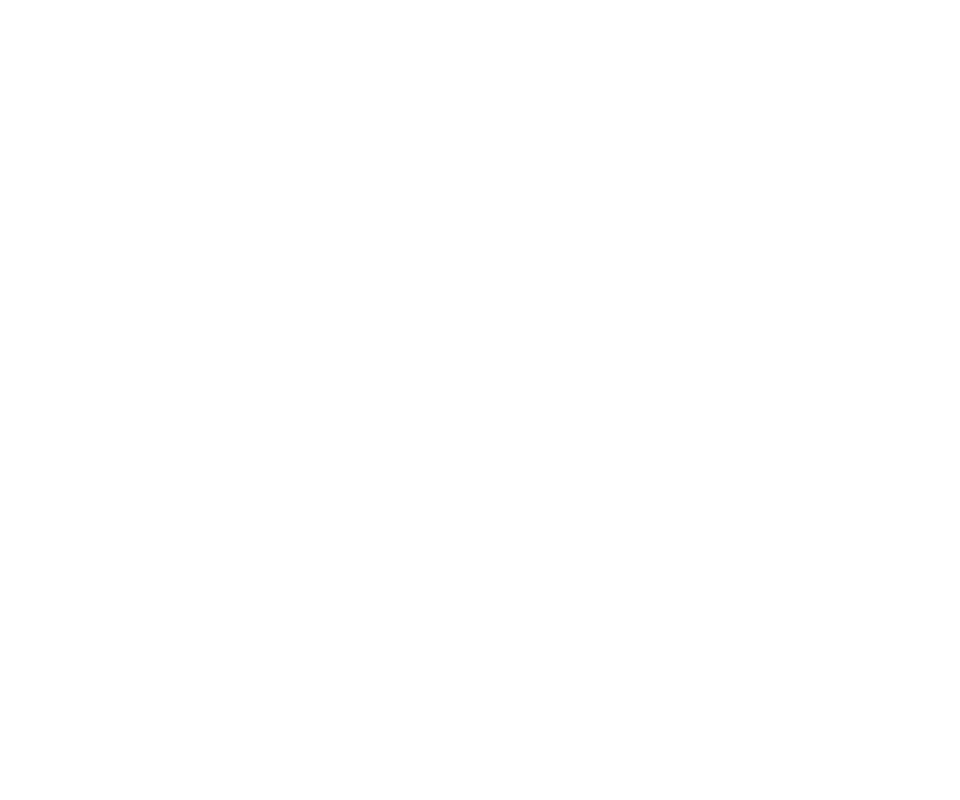

The fitted diffusion coefficient D0 is:  1.440e+04   A^2S-1
The fitted diffusion coefficient D0 is:  3.527e+04   A^2S-1
The fitted diffusion coefficient D0 is:  3.148e+04   A^2S-1


<IPython.core.display.Javascript object>


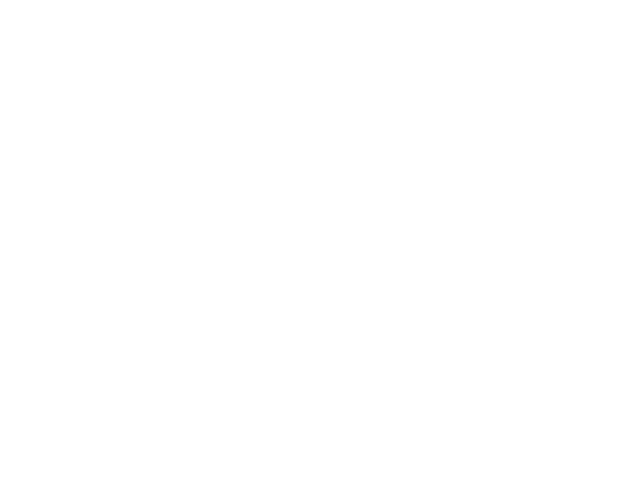

In [45]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                        path=data_dir_, uid=  uid_ + '@run--%s'%key )                      

        fit_result = fit_gisaxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.15], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.34,'alpha':1.0,'relaxation_rate':0.1},
                              one_plot= True)        
        
        fit_qr_qz_rate(  qr_center, qz_center, fit_result, power_variable= False,
                  uid=uid_ + '@run--%s'%key, path= data_dir_ )        
        psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )


# Create a report for the avergae g2

In [55]:
data_dir_

'/XF11ID/analysis/2016_2/yuzhang/Results/PEO39k_Aug02/Average/'

In [56]:
create_report = True

In [59]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=PEO39k_Aug02-average.pdf


In [60]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, out_dir = pdf_out_dir, filename = filename,
                         report_type = 'gisaxs' )
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=PEO39k_Aug02-average.pdf
****************************************


# The End!